In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn')
sns.set_palette("husl")

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/772000754.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
df = pd.read_parquet('../data/oil_and_gas_dataset.parquet')

 Dataset Column Descriptions:

 - **bandeira_revenda_cat**: Categorical - Brand category of the reseller (White Label, Blue Label, Green Label, etc.)
 - **data**: Date - Timestamp of each transaction/observation
 - **sigla_uf**: Categorical - Two-letter abbreviation of Brazilian states (SP, BA, etc.)
 - **sigla_uf_nome**: Categorical - Full name of the Brazilian state (São Paulo, Bahia, etc.)
 - **id_municipio**: Categorical - Unique identifier code for the municipality
 - **id_municipio_nome**: Categorical - Name of the municipality (São Paulo, Jaguaquara, etc.)
 - **produto**: Categorical - Type of fuel/product sold (Gasolina, Diesel, Etanol, etc.)
 - **unidade_medida**: Categorical - Unit of measurement for the product (R$/litro)
 - **n_estabelecimentos**: Numeric - Number of establishments reporting data
 - **avg_preco_compra**: Numeric - Average purchase price of the product
 - **avg_preco_venda**: Numeric - Average selling price of the product (TARGET VARIABLE)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556501 entries, 0 to 556500
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bandeira_revenda_cat  556501 non-null  object        
 1   sigla_uf              556501 non-null  object        
 2   sigla_uf_nome         556501 non-null  object        
 3   id_municipio          556501 non-null  object        
 4   id_municipio_nome     556501 non-null  object        
 5   produto               556501 non-null  object        
 6   unidade_medida        556498 non-null  object        
 7   n_estabelecimentos    556501 non-null  int64         
 8   avg_preco_compra      331360 non-null  float64       
 9   avg_preco_venda       556501 non-null  float64       
 10  data                  556501 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 46.7+ MB


In [4]:
df.head()

,bandeira_revenda_cat,sigla_uf,sigla_uf_nome,id_municipio,id_municipio_nome,produto,unidade_medida,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data
0,White Label,BA,Bahia,2917607,Jaguaquara,Gasolina,R$/litro,5,1.723251,2.030526,2004-05-01
1,Blue Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,33,1.225628,1.397636,2004-05-01
2,Green Label,SP,São Paulo,3550308,São Paulo,Diesel,R$/litro,128,1.224991,1.415282,2004-05-01
3,Green Label,SP,São Paulo,3505708,Barueri,Etanol,R$/litro,5,0.619567,0.856467,2004-05-01
4,White Label,SP,São Paulo,3513009,Cotia,Etanol,R$/litro,21,0.604228,0.804345,2004-05-01


# Split train, test, validation for best practives


In [39]:
# Split data into training, validation, and test sets
# Training: Data up to 2022-12-31
# Validation: Data from 2023-01-01 to 2023-12-31
# Test: Data from 2024-01-01 to 2024-05-31 (most recent data before prediction period)
# Prediction target: June, July, August 2024

train_df = df[df['data'] < '2023-01-01']
validation_df = df[(df['data'] >= '2023-01-01') & (df['data'] < '2024-01-01')]
test_df = df[(df['data'] >= '2024-01-01') & (df['data'] < '2024-06-01')]

print(f"Training data: {train_df['data'].min()} to {train_df['data'].max()}")
print(f"Validation data: {validation_df['data'].min()} to {validation_df['data'].max()}")
print(f"Test data: {test_df['data'].min()} to {test_df['data'].max()}")
print(f"Prediction target: June, July, August 2024")


Training data: 2004-05-01 00:00:00 to 2022-12-01 00:00:00
Validation data: 2023-01-01 00:00:00 to 2023-12-01 00:00:00
Test data: 2024-01-01 00:00:00 to 2024-05-01 00:00:00
Prediction target: June, July, August 2024


# Exploration of the data

In [17]:
# Basic dataset information
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
bandeira_revenda_cat         0
sigla_uf                     0
sigla_uf_nome                0
id_municipio                 0
id_municipio_nome            0
produto                      0
unidade_medida               3
n_estabelecimentos           0
avg_preco_compra        225141
avg_preco_venda              0
data                         0
dtype: int64


In [34]:
# Basic statistics for numerical columns
print("\nNumerical Columns Statistics:")
df.describe()


Numerical Columns Statistics:


,n_estabelecimentos,avg_preco_compra,avg_preco_venda,data,price_spread
count,556501.000000,331360.000000,556501.000000,556501,331360.000000
mean,6.343187,2.278602,3.270554,2015-04-05 23:16:10.432758016,0.353421
min,1.000000,0.413200,0.668744,2004-05-01 00:00:00,-0.881850
25%,2.000000,1.746553,2.205714,2010-07-01 00:00:00,0.244500
50%,3.000000,2.190800,2.894286,2015-07-01 00:00:00,0.334484
75%,6.000000,2.649900,3.967500,2020-03-01 00:00:00,0.439000
max,1096.000000,4.747100,8.990000,2024-08-01 00:00:00,1.893158
std,15.529743,0.713028,1.390611,NaN,0.147754


In [18]:
# Unique values in categorical columns
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head())
    print(f"Total unique values: {df[col].nunique()}")


Unique values in categorical columns:

bandeira_revenda_cat:
bandeira_revenda_cat
White Label     188545
Blue Label      132196
Green Label     125752
Purple Label    110008
Name: count, dtype: int64
Total unique values: 4

sigla_uf:
sigla_uf
SP    140240
MG     71434
RS     45389
RJ     41751
PR     37421
Name: count, dtype: int64
Total unique values: 27

sigla_uf_nome:
sigla_uf_nome
São Paulo            140240
Minas Gerais          71434
Rio Grande do Sul     45389
Rio de Janeiro        41751
Paraná                37421
Name: count, dtype: int64
Total unique values: 27

id_municipio:
id_municipio
3304557    1525
5300108    1524
5208707    1523
2927408    1513
3550308    1503
Name: count, dtype: int64
Total unique values: 690

id_municipio_nome:
id_municipio_nome
Valença           2041
Cascavel          1597
Rio de Janeiro    1525
Brasília          1524
Goiânia           1523
Name: count, dtype: int64
Total unique values: 688

produto:
produto
Gasolina    194711
Etanol      185910
Di

In [19]:
# Time series analysis
print("\nDate range in the dataset:")
print(f"Start date: {df['data'].min()}")
print(f"End date: {df['data'].max()}")


Date range in the dataset:
Start date: 2004-05-01 00:00:00
End date: 2024-08-01 00:00:00


In [ ]:
# Pair plot histograms with seaborn
cols= ['bandeira_revenda_cat', 'sigla_uf_nome', 'id_municipio_nome', 'produto', 'n_estabelecimentos', 'avg_preco_compra', 'avg_preco_venda']
sns.pairplot(df[cols], hue='produto')
plt.show()


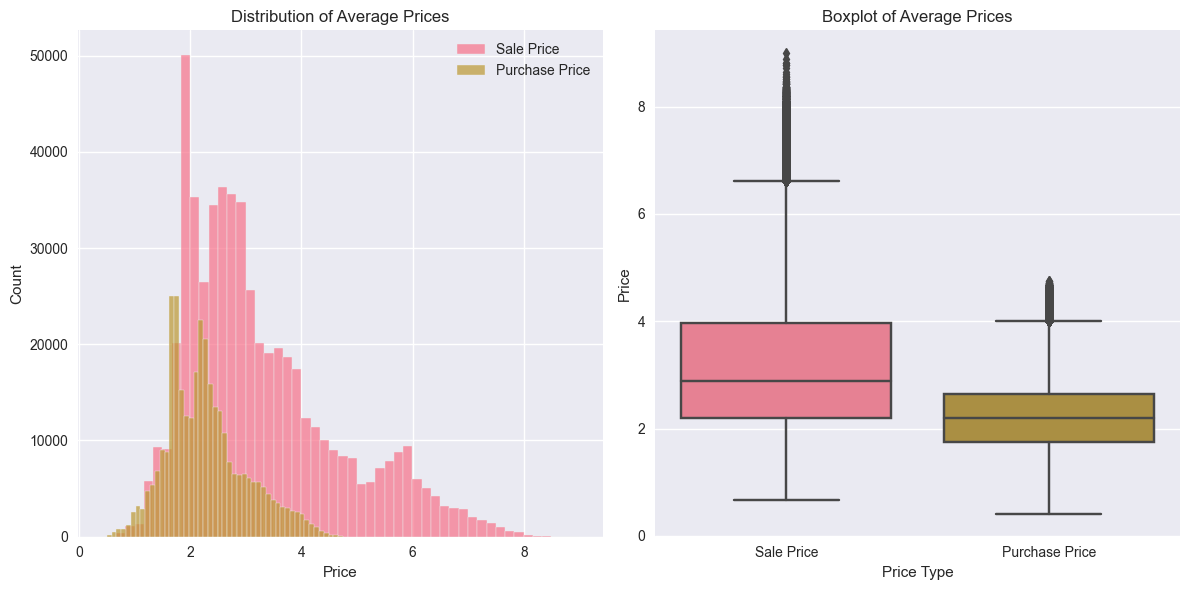

In [38]:
# 1. Price Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='avg_preco_venda', bins=50, label='Sale Price', alpha=0.7)
sns.histplot(data=df, x='avg_preco_compra', bins=50, label='Purchase Price', alpha=0.7)
plt.title('Distribution of Average Prices')
plt.xlabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
df_melt = df.melt(value_vars=['avg_preco_venda', 'avg_preco_compra'], 
                  var_name='Price Type', value_name='Price')
sns.boxplot(x='Price Type', y='Price', data=df_melt)
plt.title('Boxplot of Average Prices')
plt.xticks([0, 1], ['Sale Price', 'Purchase Price'])
plt.tight_layout()
plt.show()

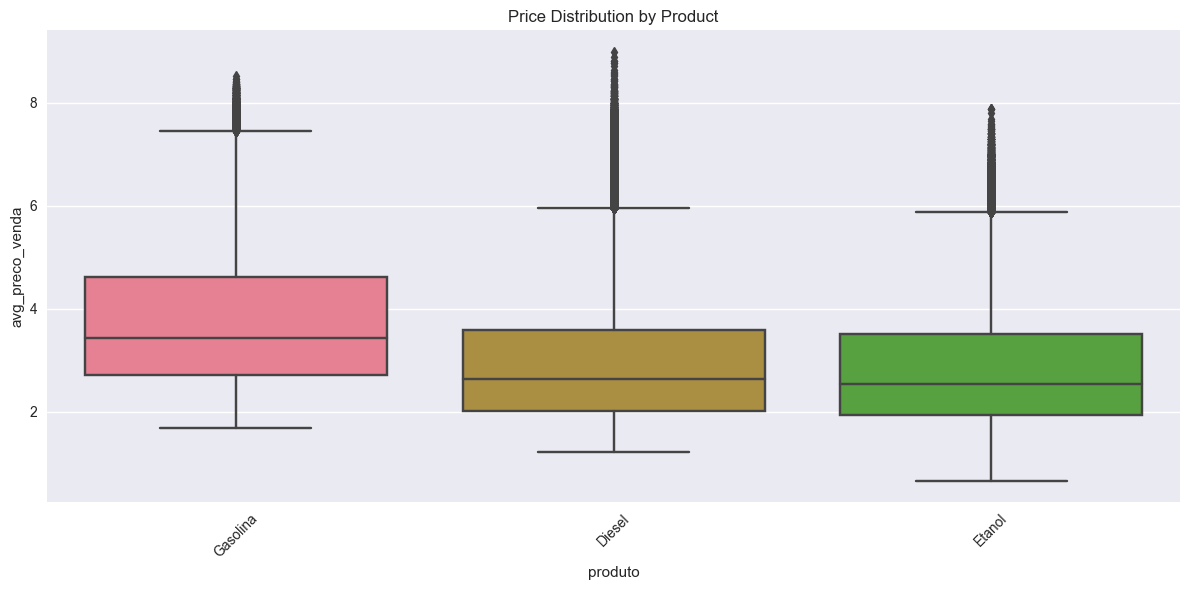

In [22]:
# 2. Price Comparison by Product
plt.figure(figsize=(12, 6))
sns.boxplot(x='produto', y='avg_preco_venda', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Product')
plt.tight_layout()
plt.show()


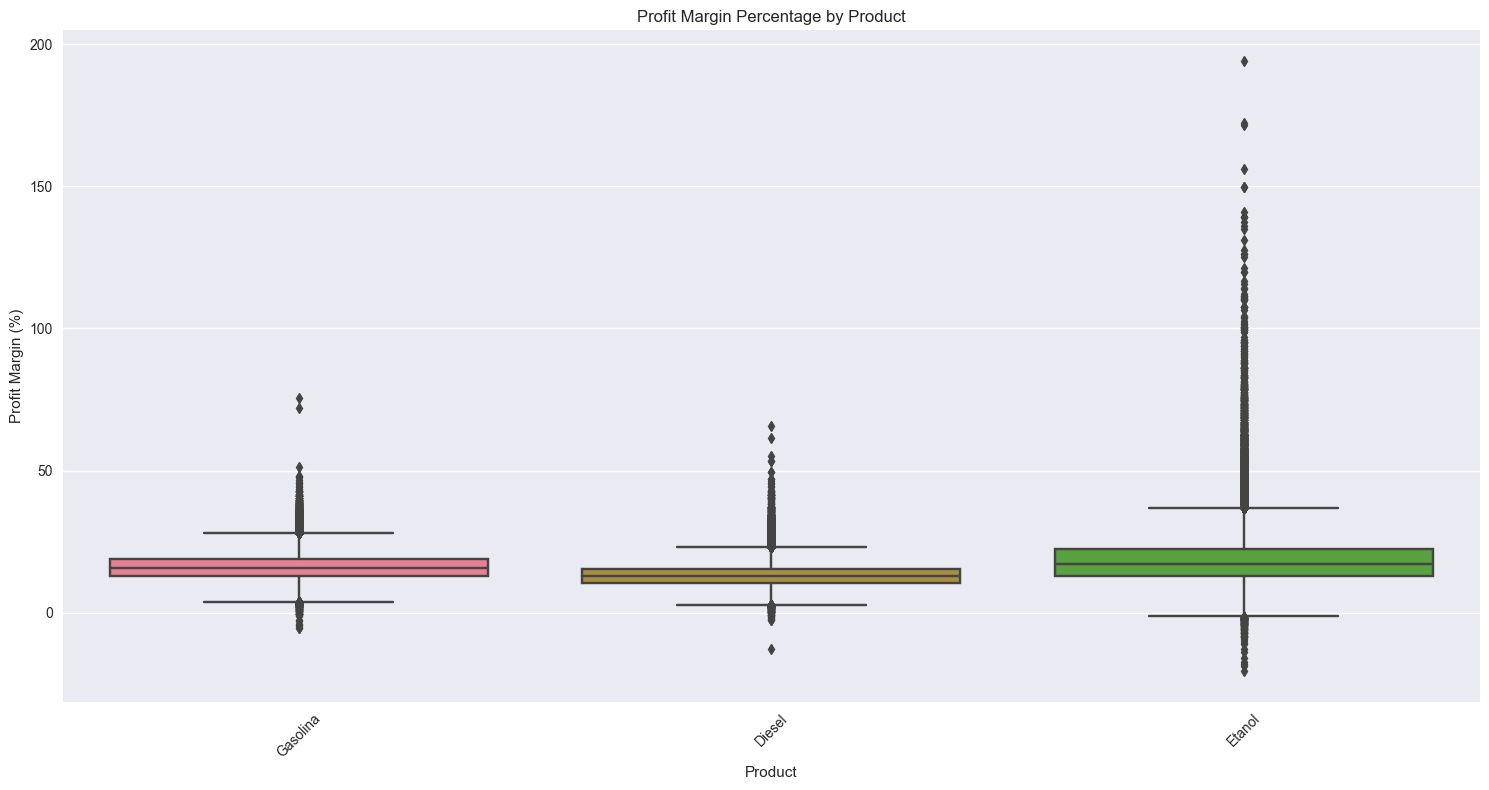

In [50]:
# 7. Profit Margin Analysis
plt.figure(figsize=(15, 8))
# Calculate profit margin percentage
df['profit_margin_pct'] = ((df['avg_preco_venda'] - df['avg_preco_compra']) / df['avg_preco_compra']) * 100

# Plot profit margin by product
sns.boxplot(x='produto', y='profit_margin_pct', data=df)
plt.title('Profit Margin Percentage by Product')
plt.xlabel('Product')
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_16244/1266716772.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


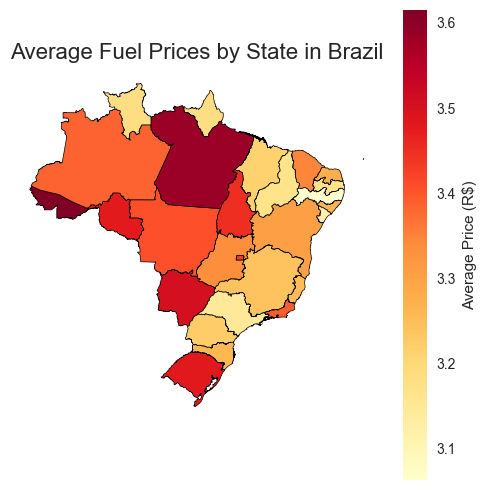

In [37]:
# Import required libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import Normalize

# Try to use GeoPandas sample data
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = brazil[brazil.name == 'Brazil']

# Get state-level data for Brazil
states_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brazil_states = gpd.read_file(states_url)

# Calculate average prices by state
avg_price_by_state = df.groupby('sigla_uf')['avg_preco_venda'].mean()

# Create a mapping dictionary from state codes to state names
state_code_to_name = df[['sigla_uf', 'sigla_uf_nome']].drop_duplicates().set_index('sigla_uf')['sigla_uf_nome'].to_dict()

# Map state codes to names in the GeoJSON
brazil_states['state_code'] = brazil_states['name'].map({v: k for k, v in state_code_to_name.items()})

# Add average prices to the GeoDataFrame
brazil_states['avg_price'] = brazil_states['state_code'].map(avg_price_by_state)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Create colormap
cmap = 'YlOrRd'
norm = Normalize(vmin=avg_price_by_state.min(), vmax=avg_price_by_state.max())

# Plot the states with colors based on prices
brazil_states.plot(column='avg_price', 
                    cmap=cmap,
                    ax=ax,
                    edgecolor='black',
                    linewidth=0.5,
                    legend=True,
                    legend_kwds={'label': 'Average Price (R$)'})

# Customize plot
plt.title('Average Fuel Prices by State in Brazil', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
    

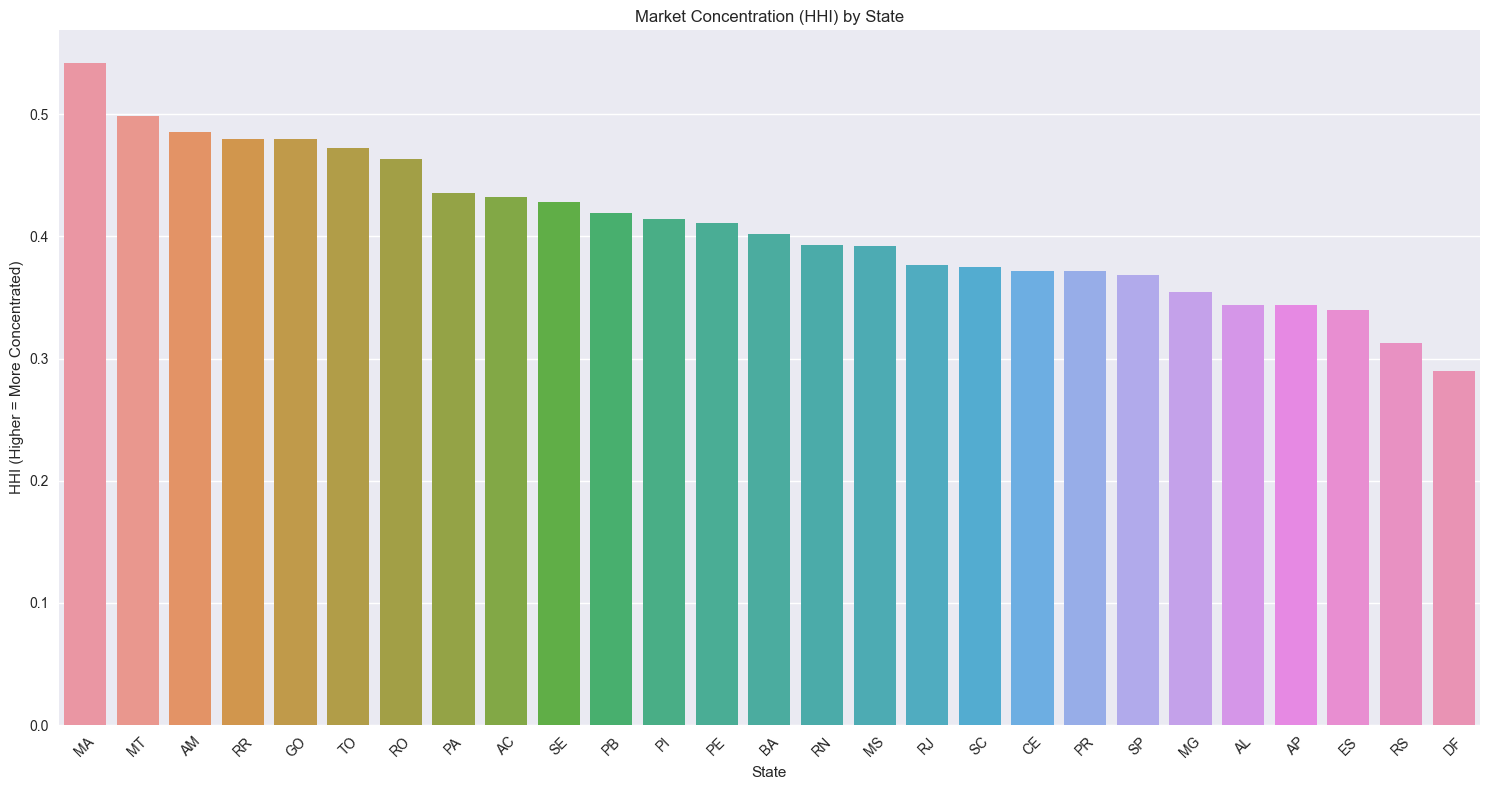

In [46]:
# 5. Market Concentration Analysis
plt.figure(figsize=(15, 8))
# Calculate Herfindahl-Hirschman Index (HHI) for market concentration
# Group by state and retailer
market_share = df.groupby(['sigla_uf', 'bandeira_revenda_cat'])['n_estabelecimentos'].sum().reset_index()
# Calculate total establishments by state
total_by_state = market_share.groupby('sigla_uf')['n_estabelecimentos'].sum().reset_index()
# Merge to get market share
market_share = market_share.merge(total_by_state, on='sigla_uf', suffixes=('', '_total'))
market_share['market_share'] = market_share['n_estabelecimentos'] / market_share['n_estabelecimentos_total']
# Calculate HHI (sum of squared market shares)
hhi_by_state = market_share.groupby('sigla_uf').apply(lambda x: (x['market_share']**2).sum()).sort_values(ascending=False)

# Plot HHI by state
sns.barplot(x=hhi_by_state.index, y=hhi_by_state.values)
plt.title('Market Concentration (HHI) by State')
plt.xlabel('State')
plt.ylabel('HHI (Higher = More Concentrated)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



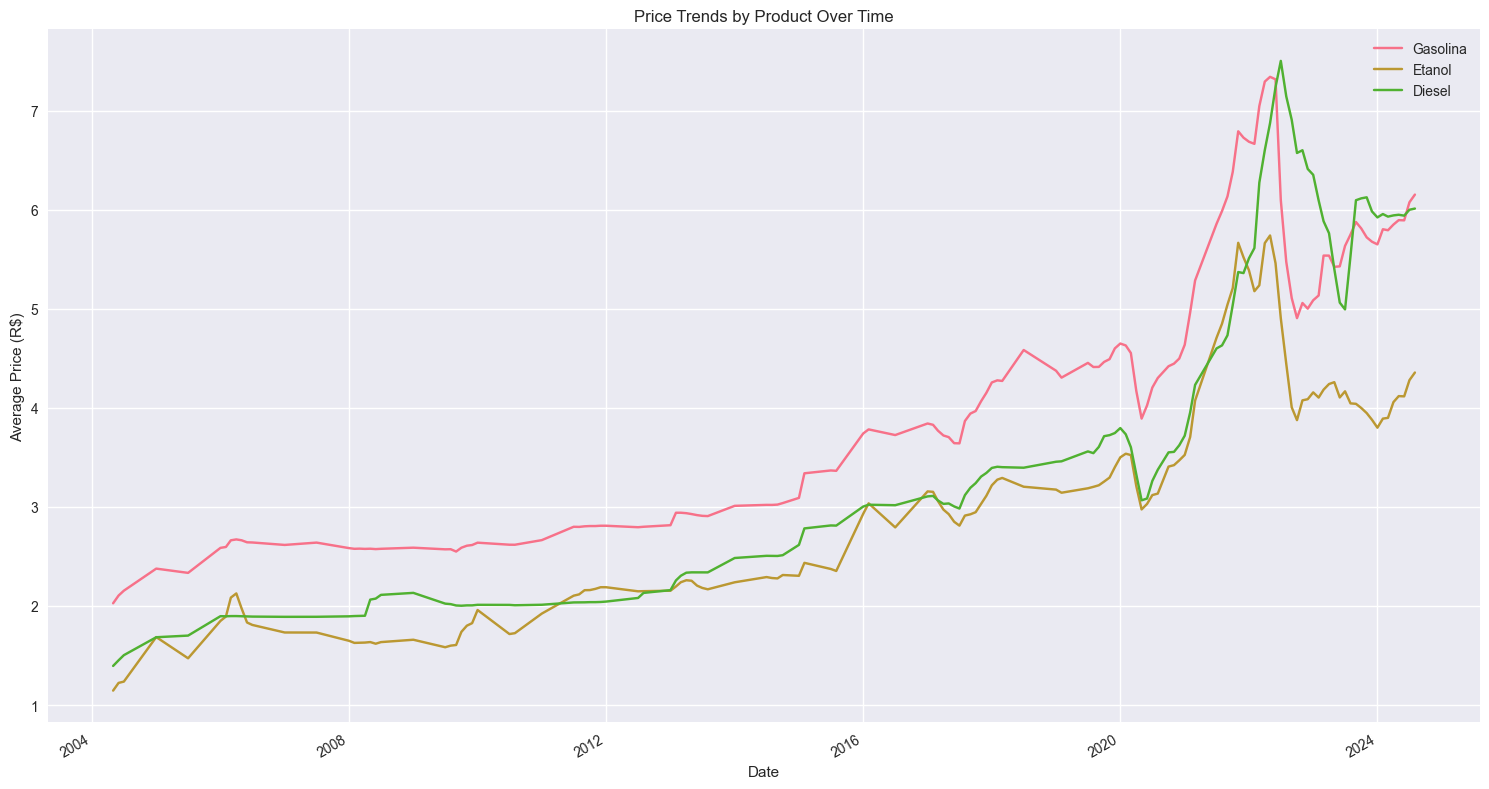

In [41]:
#Temporal Price Trends by Product
plt.figure(figsize=(15, 8))
# Select the most common products for clarity
top_products = df['produto'].value_counts().nlargest(5).index
df_top_products = df[df['produto'].isin(top_products)]

# Plot time series for each product
for product in top_products:
    product_data = df_top_products[df_top_products['produto'] == product]
    product_data.groupby('data')['avg_preco_venda'].mean().plot(label=product)

plt.title('Price Trends by Product Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


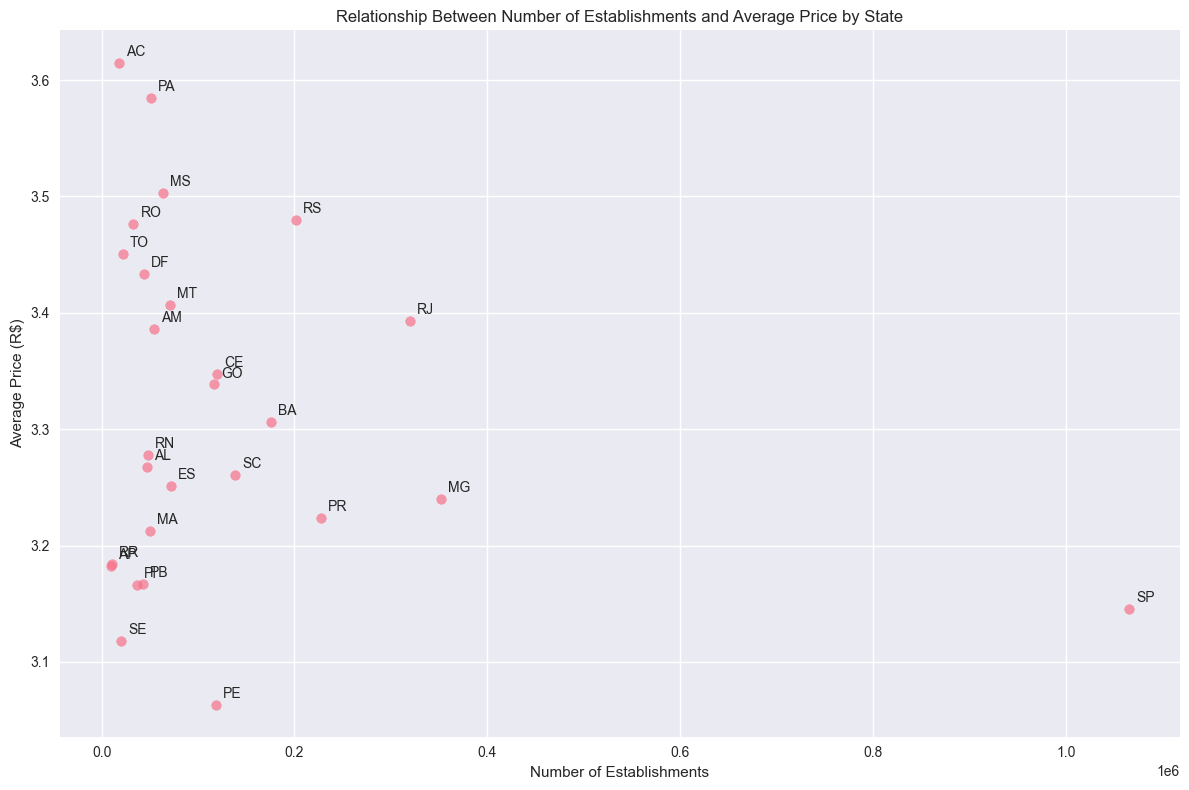

In [47]:
# 6. Price-Establishment Relationship
plt.figure(figsize=(12, 8))
# Group by state and calculate average price and number of establishments
state_summary = df.groupby('sigla_uf').agg({
    'avg_preco_venda': 'mean',
    'n_estabelecimentos': 'sum'
}).reset_index()

# Create scatter plot
plt.scatter(state_summary['n_estabelecimentos'], state_summary['avg_preco_venda'], alpha=0.7)
# Add state labels to points
for i, row in state_summary.iterrows():
    plt.annotate(row['sigla_uf'], 
                (row['n_estabelecimentos'], row['avg_preco_venda']),
                xytext=(5, 5), textcoords='offset points')

plt.title('Relationship Between Number of Establishments and Average Price by State')
plt.xlabel('Number of Establishments')
plt.ylabel('Average Price (R$)')
plt.grid(True)
plt.tight_layout()
plt.show()

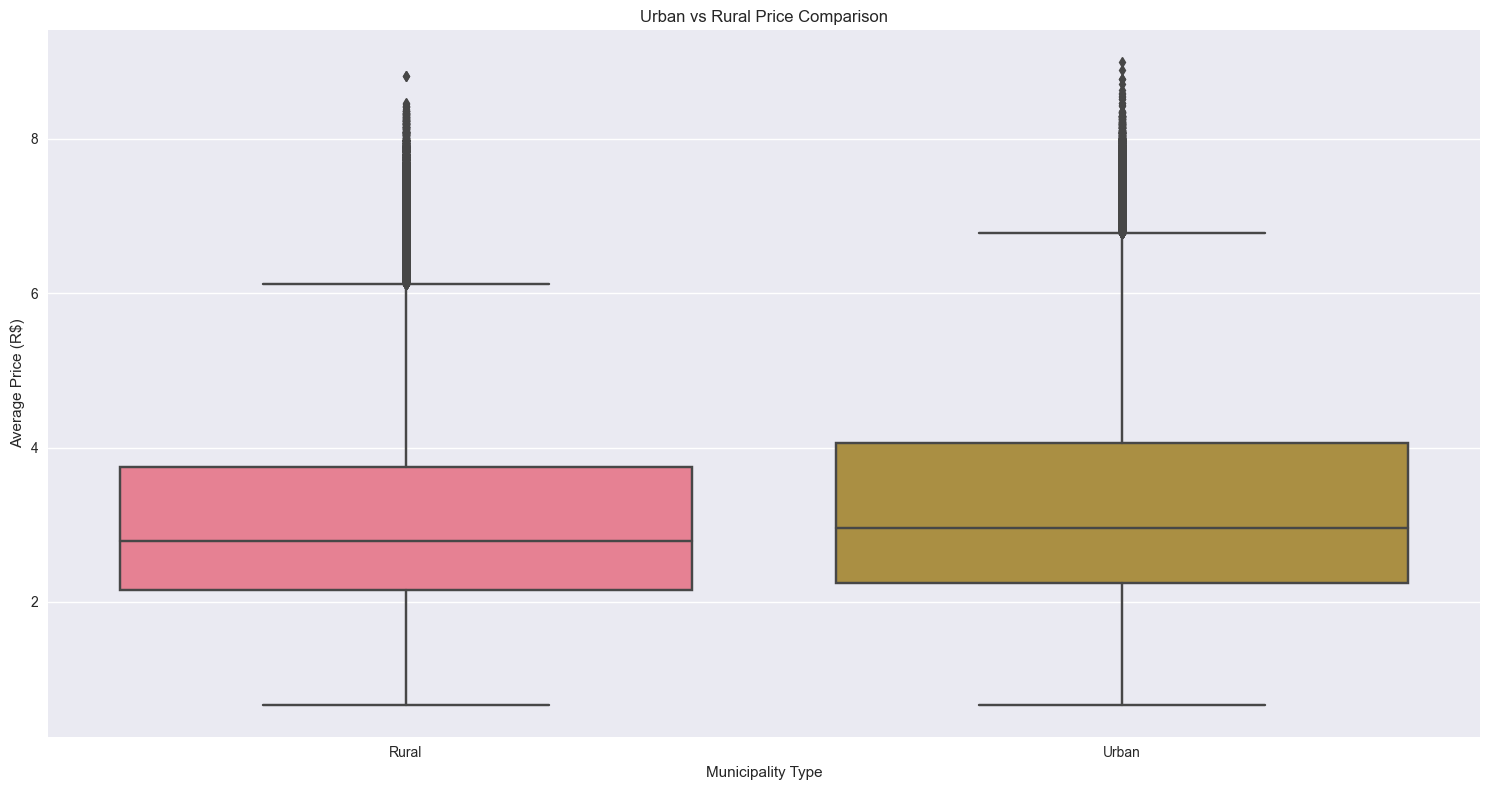

In [51]:
# 8. Urban vs Rural Price Comparison
# Assuming larger municipalities have more establishments
plt.figure(figsize=(15, 8))
# Calculate average establishments per municipality
municipality_size = df.groupby('id_municipio')['n_estabelecimentos'].mean().reset_index()
# Define urban/rural threshold (median or other meaningful value)
urban_threshold = municipality_size['n_estabelecimentos'].median()
# Classify municipalities
municipality_size['type'] = municipality_size['n_estabelecimentos'].apply(
    lambda x: 'Urban' if x >= urban_threshold else 'Rural')
# Merge back to original data
df_with_type = df.merge(municipality_size[['id_municipio', 'type']], on='id_municipio')
# Compare prices
sns.boxplot(x='type', y='avg_preco_venda', data=df_with_type)
plt.title('Urban vs Rural Price Comparison')
plt.xlabel('Municipality Type')
plt.ylabel('Average Price (R$)')
plt.tight_layout()
plt.show()

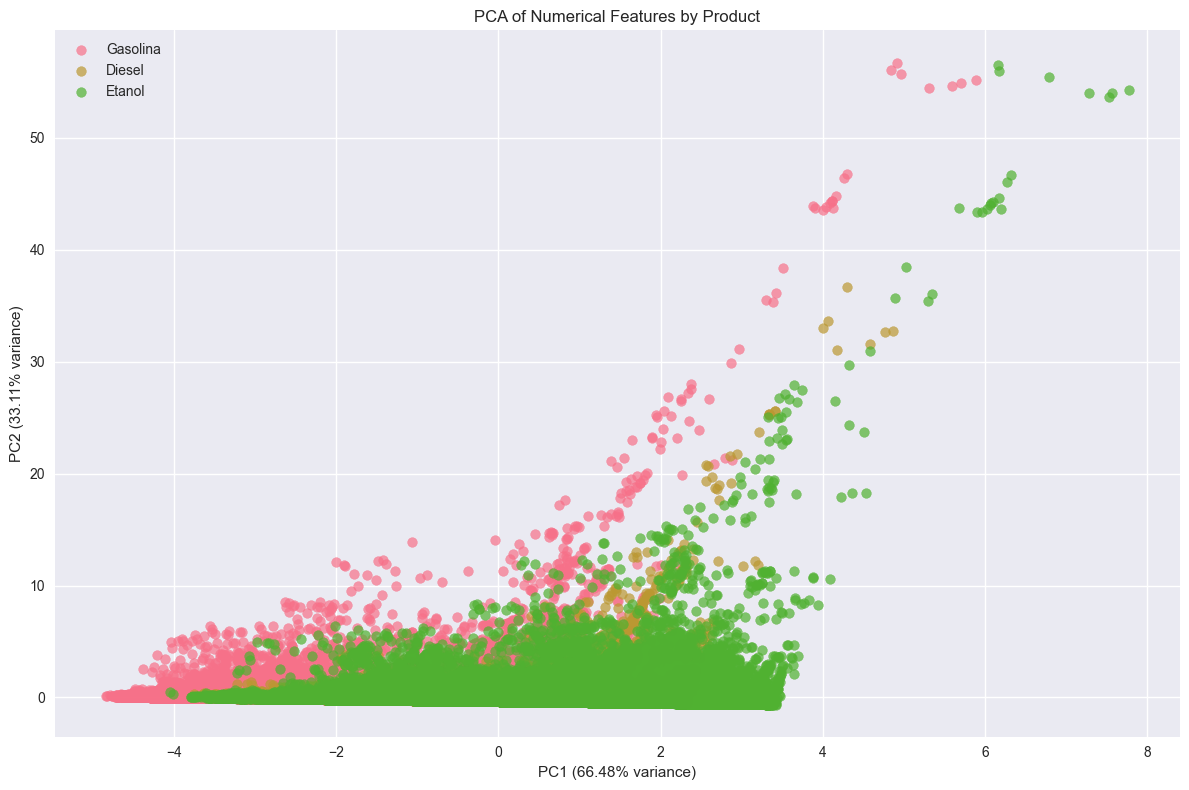

In [54]:
# 10. Multivariate Analysis with PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numerical columns
numerical_cols = ['n_estabelecimentos', 'avg_preco_compra', 'avg_preco_venda']
# Standardize the data
scaler = StandardScaler()
# Drop rows with NaN values before applying PCA
df_clean = df[numerical_cols].dropna()
scaled_data = scaler.fit_transform(df_clean)
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
# Get corresponding product values from the cleaned dataframe
pca_df['produto'] = df.loc[df_clean.index, 'produto'].values

# Plot PCA results
plt.figure(figsize=(12, 8))
for product in pca_df['produto'].unique():
    subset = pca_df[pca_df['produto'] == product]
    plt.scatter(subset['PC1'], subset['PC2'], label=product, alpha=0.7)
plt.title('PCA of Numerical Features by Product')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Time series analysis

/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


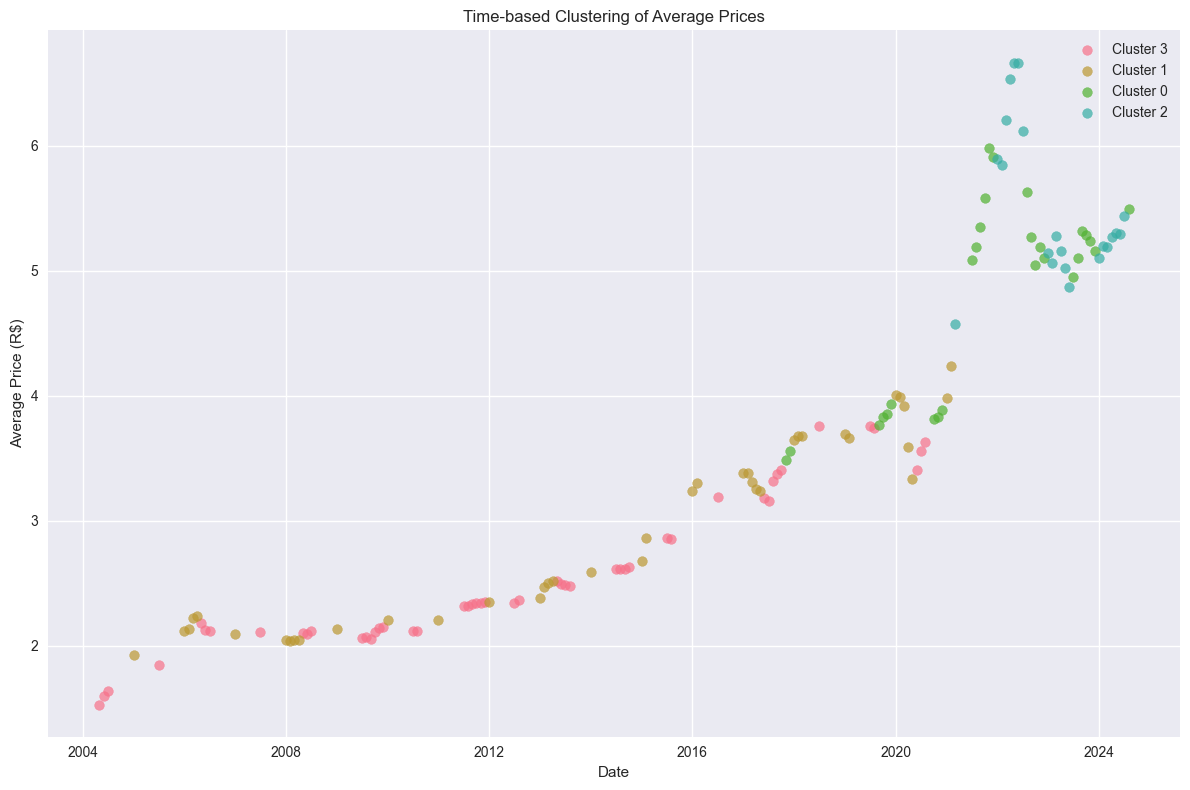

In [55]:
# 11. Time-based Clustering
from sklearn.cluster import KMeans
# Prepare time-based features
time_features = df.groupby('data')['avg_preco_venda'].mean().reset_index()
time_features['year'] = time_features['data'].dt.year
time_features['month'] = time_features['data'].dt.month
time_features['day_of_week'] = time_features['data'].dt.dayofweek
# Standardize
X = StandardScaler().fit_transform(time_features[['avg_preco_venda', 'month']])
# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
time_features['cluster'] = kmeans.fit_predict(X)
# Plot clusters
plt.figure(figsize=(12, 8))
for cluster in time_features['cluster'].unique():
    subset = time_features[time_features['cluster'] == cluster]
    plt.scatter(subset['data'], subset['avg_preco_venda'], label=f'Cluster {cluster}', alpha=0.7)
plt.title('Time-based Clustering of Average Prices')
plt.xlabel('Date')
plt.ylabel('Average Price (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

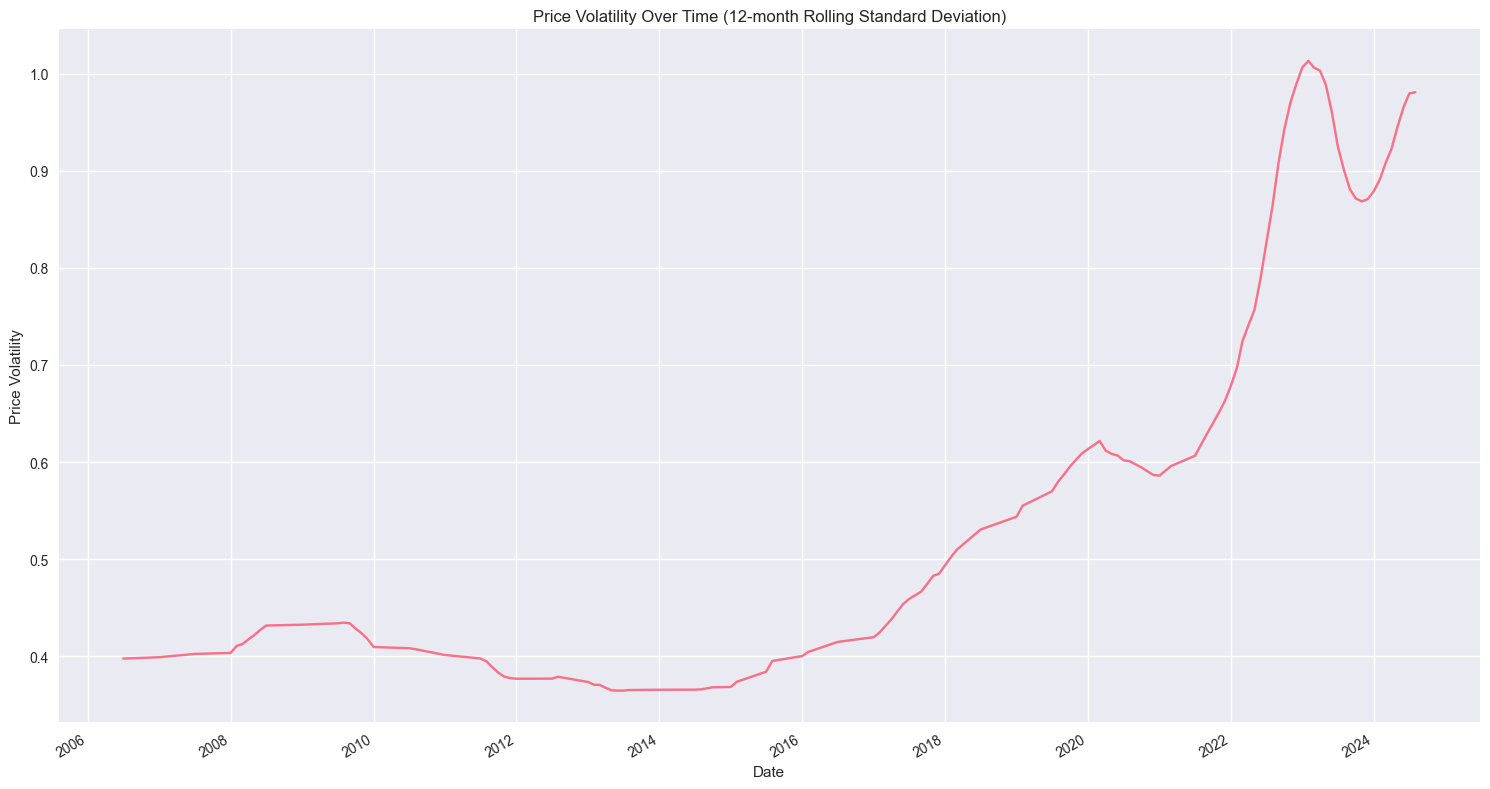

In [43]:
# 3. Price Volatility Analysis
plt.figure(figsize=(15, 8))
# Calculate rolling standard deviation (volatility)
volatility = df.groupby('data')['avg_preco_venda'].std().rolling(window=12).mean()
volatility.plot()
plt.title('Price Volatility Over Time (12-month Rolling Standard Deviation)')
plt.xlabel('Date')
plt.ylabel('Price Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

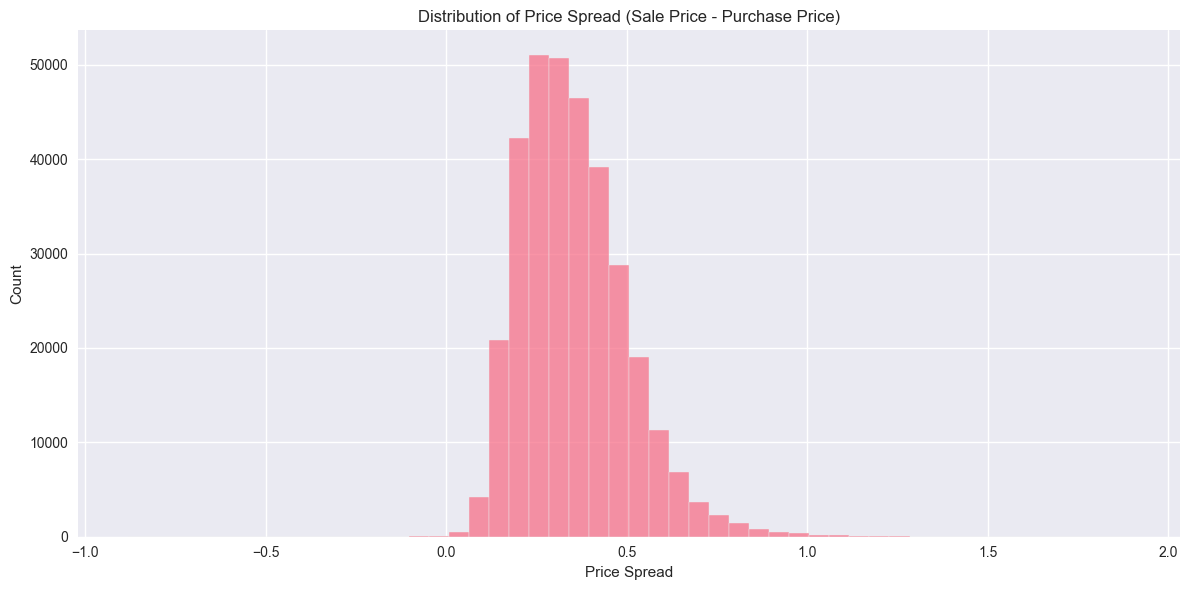

In [28]:
# 5. Price Spread Analysis
df['price_spread'] = df['avg_preco_venda'] - df['avg_preco_compra']
plt.figure(figsize=(12, 6))
sns.histplot(df['price_spread'], bins=50)
plt.title('Distribution of Price Spread (Sale Price - Purchase Price)')
plt.xlabel('Price Spread')
plt.tight_layout()
plt.show()

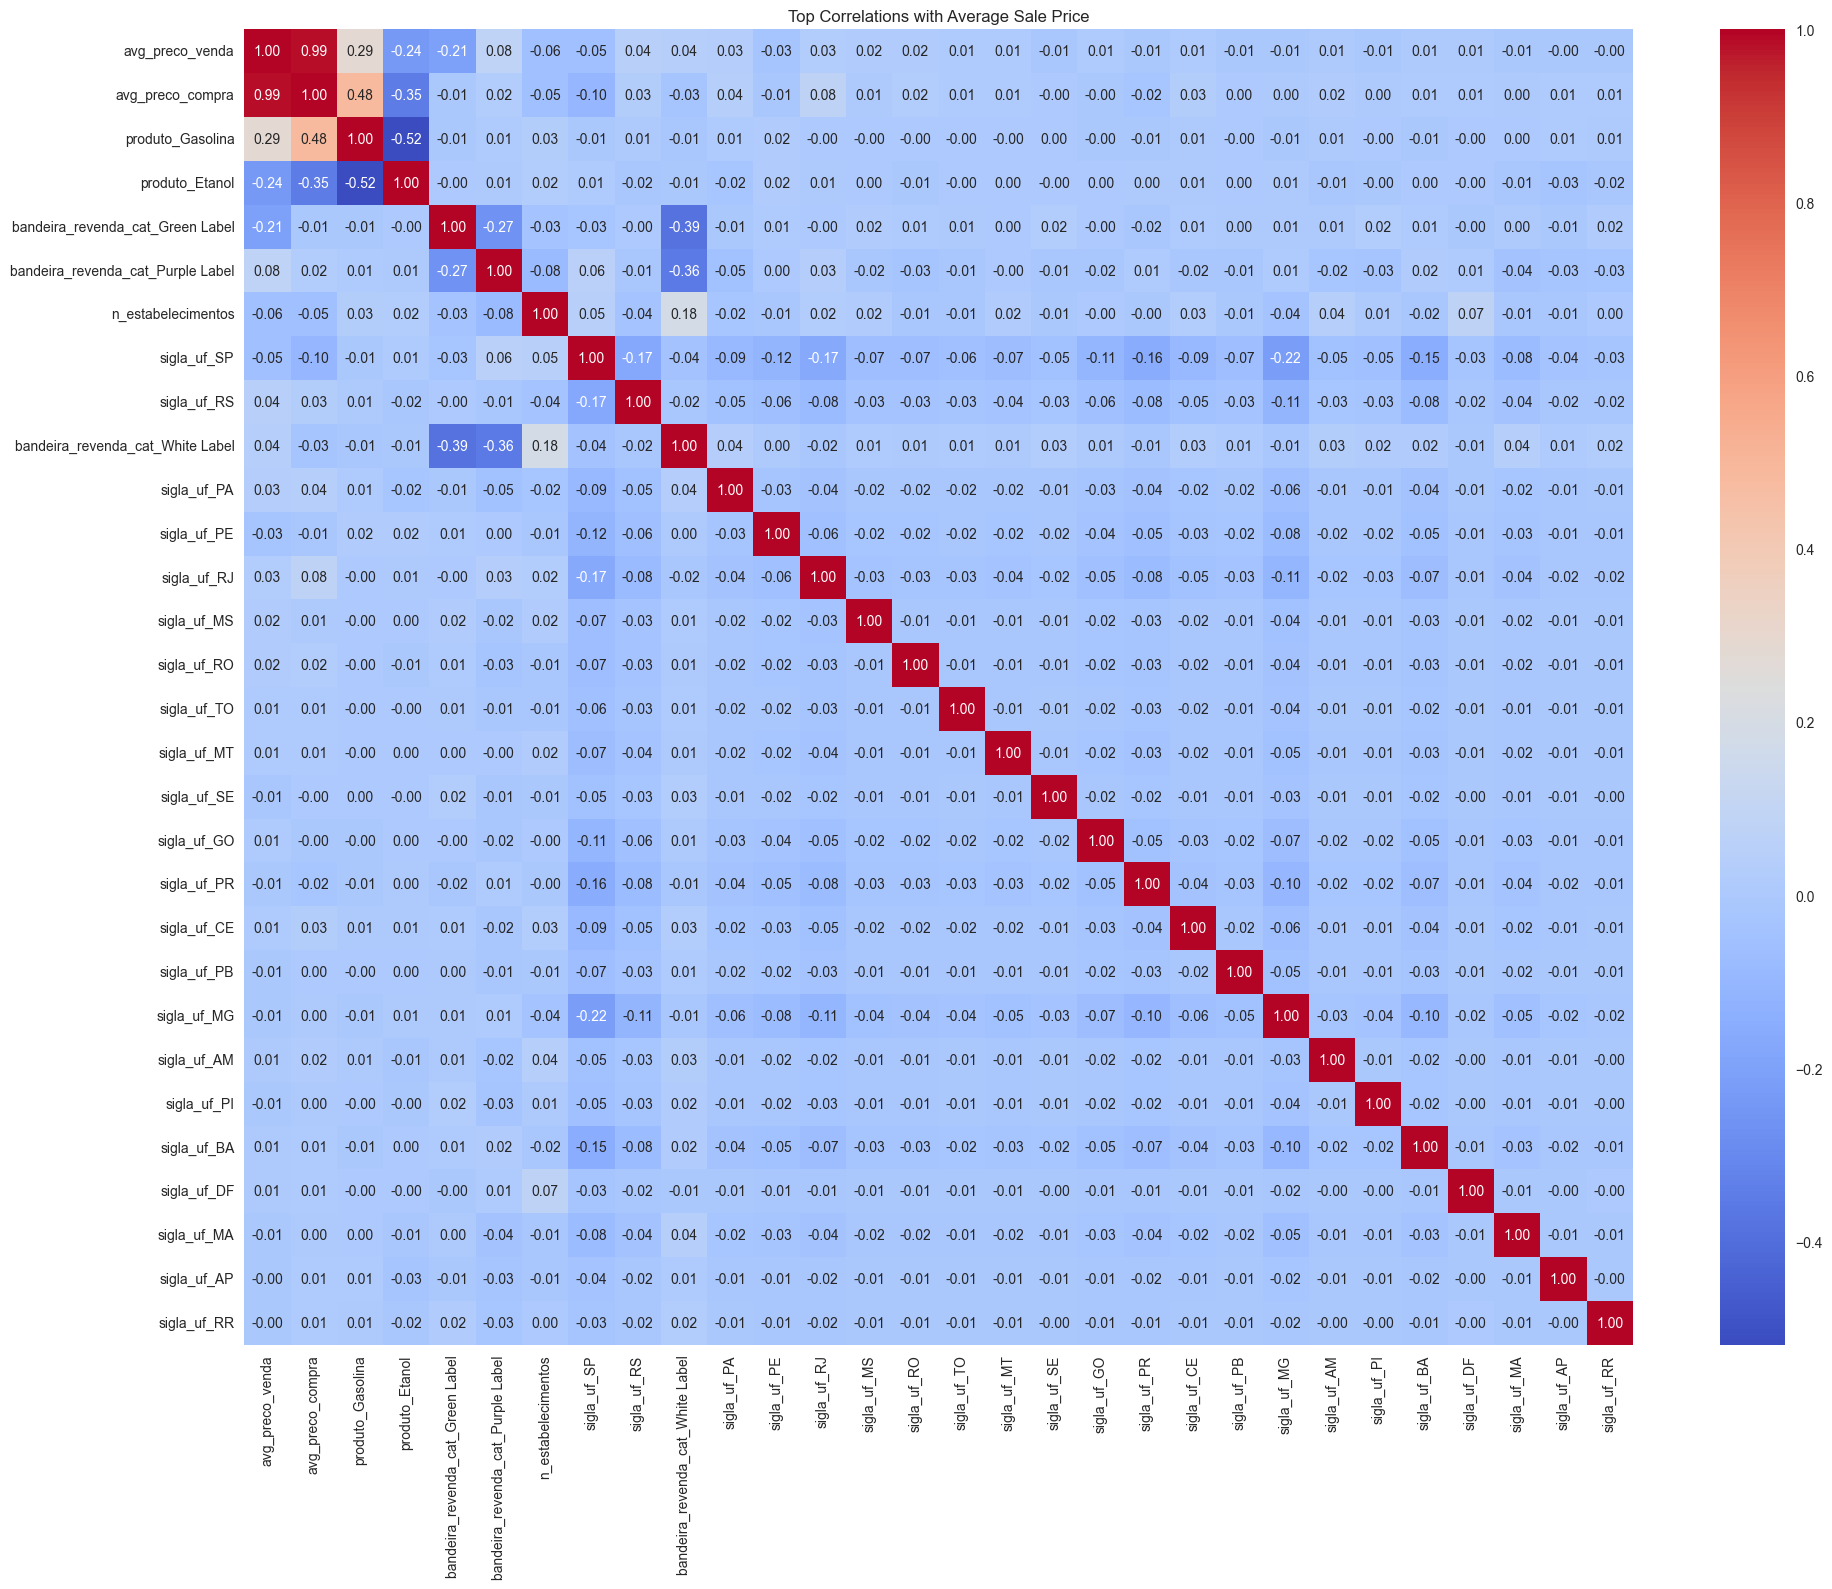

In [56]:
# 12. Correlation Heatmap with All Variables
# Create dummy variables for categorical columns
categorical_cols = ['bandeira_revenda_cat', 'sigla_uf', 'produto']
df_encoded = pd.get_dummies(df[categorical_cols + ['n_estabelecimentos', 'avg_preco_compra', 'avg_preco_venda']], 
                           columns=categorical_cols, drop_first=True)
# Calculate correlation matrix
corr_matrix = df_encoded.corr()
# Plot heatmap (top correlations only)
plt.figure(figsize=(20, 16))
# Get the top 30 correlations with avg_preco_venda
top_corr = corr_matrix['avg_preco_venda'].abs().sort_values(ascending=False).head(30).index
sns.heatmap(corr_matrix.loc[top_corr, top_corr], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlations with Average Sale Price')
plt.tight_layout()
plt.show()

In [27]:
# Additional Analysis: Market Concentration
print("\nMarket Analysis by Retailer:")
retailer_stats = df.groupby('bandeira_revenda_cat').agg({
    'n_estabelecimentos': 'sum',
    'avg_preco_venda': 'mean'
}).sort_values('n_estabelecimentos', ascending=False)

print(retailer_stats.head(10))

# Save key findings
key_findings = {
    'total_records': len(df),
    'date_range': f"{df['data'].min()} to {df['data'].max()}",
    'avg_sale_price': df['avg_preco_venda'].mean(),
    'price_range': f"{df['avg_preco_venda'].min():.2f} to {df['avg_preco_venda'].max():.2f}",
    'most_common_product': df['produto'].mode()[0],
    'n_retailers': df['bandeira_revenda_cat'].nunique(),
    'n_cities': df['id_municipio'].nunique()
}

print("\nKey Findings:")
for key, value in key_findings.items():
    print(f"{key}: {value}")


Market Analysis by Retailer:
                      n_estabelecimentos  avg_preco_venda
bandeira_revenda_cat                                     
White Label                      1938767         3.350552
Green Label                       673775         2.728655
Blue Label                        499683         3.474524
Purple Label                      417765         3.507789

Key Findings:
total_records: 556501
date_range: 2004-05-01 00:00:00 to 2024-08-01 00:00:00
avg_sale_price: 3.2705543433509683
price_range: 0.67 to 8.99
most_common_product: Gasolina
n_retailers: 4
n_cities: 690


# Network analysis

Node Addition:
State Nodes: Each Brazilian state is added as a node with attributes:
    type: Set to 'state' to distinguish from retailers
    avg_price: The average fuel price in that state
    establishments: Total number of fuel establishments in that state
    Retailer Nodes: Each fuel retailer brand is added as a node with attributes:
    type: Set to 'retailer' to distinguish from states
    avg_price: The average fuel price for that retailer
    establishments: Total number of establishments for that retailer

Edge Creation:
    For each state, we find all retailers operating in that state
    We create an edge between the state and each retailer
    The edge weight is set to the number of establishments that retailer has in that state
    This creates a bipartite graph structure (connections only between states and retailers, not state-state or retailer-retailer)

In [58]:
# Network Analysis of Fuel Distribution
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import Normalize
import seaborn as sns

# 1. Create a network graph of fuel distribution
print("Building network analysis of the fuel distribution system...")

# Create a graph
G = nx.Graph()

# Add nodes for states and retailers
states = df['sigla_uf'].unique()
retailers = df['bandeira_revenda_cat'].unique()

# Add state nodes
for state in states:
    G.add_node(state, type='state', 
               avg_price=df[df['sigla_uf']==state]['avg_preco_venda'].mean(),
               establishments=df[df['sigla_uf']==state]['n_estabelecimentos'].sum())

# Add retailer nodes
for retailer in retailers:
    G.add_node(retailer, type='retailer',
               avg_price=df[df['bandeira_revenda_cat']==retailer]['avg_preco_venda'].mean(),
               establishments=df[df['bandeira_revenda_cat']==retailer]['n_estabelecimentos'].sum())

# Add edges between retailers and states based on presence
for state in states:
    state_retailers = df[df['sigla_uf']==state]['bandeira_revenda_cat'].unique()
    for retailer in state_retailers:
        # Calculate the weight based on number of establishments
        weight = df[(df['sigla_uf']==state) & 
                    (df['bandeira_revenda_cat']==retailer)]['n_estabelecimentos'].sum()
        G.add_edge(state, retailer, weight=weight)


Building network analysis of the fuel distribution system...


In [64]:
# 2. Calculate network metrics
print("\nCalculating network centrality metrics...")

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
# Calculate eigenvector centrality
#eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Create a dataframe with the centrality metrics
centrality_df = pd.DataFrame({
    'node': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values()),
    # 'eigenvector_centrality': list(eigenvector_centrality.values())
})

# Add node type
centrality_df['type'] = centrality_df['node'].apply(
    lambda x: 'state' if x in states else 'retailer')




Calculating network centrality metrics...



Visualizing the distribution network...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_16244/975541111.py:49: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', connectionstyle='arc3,rad=0.1')


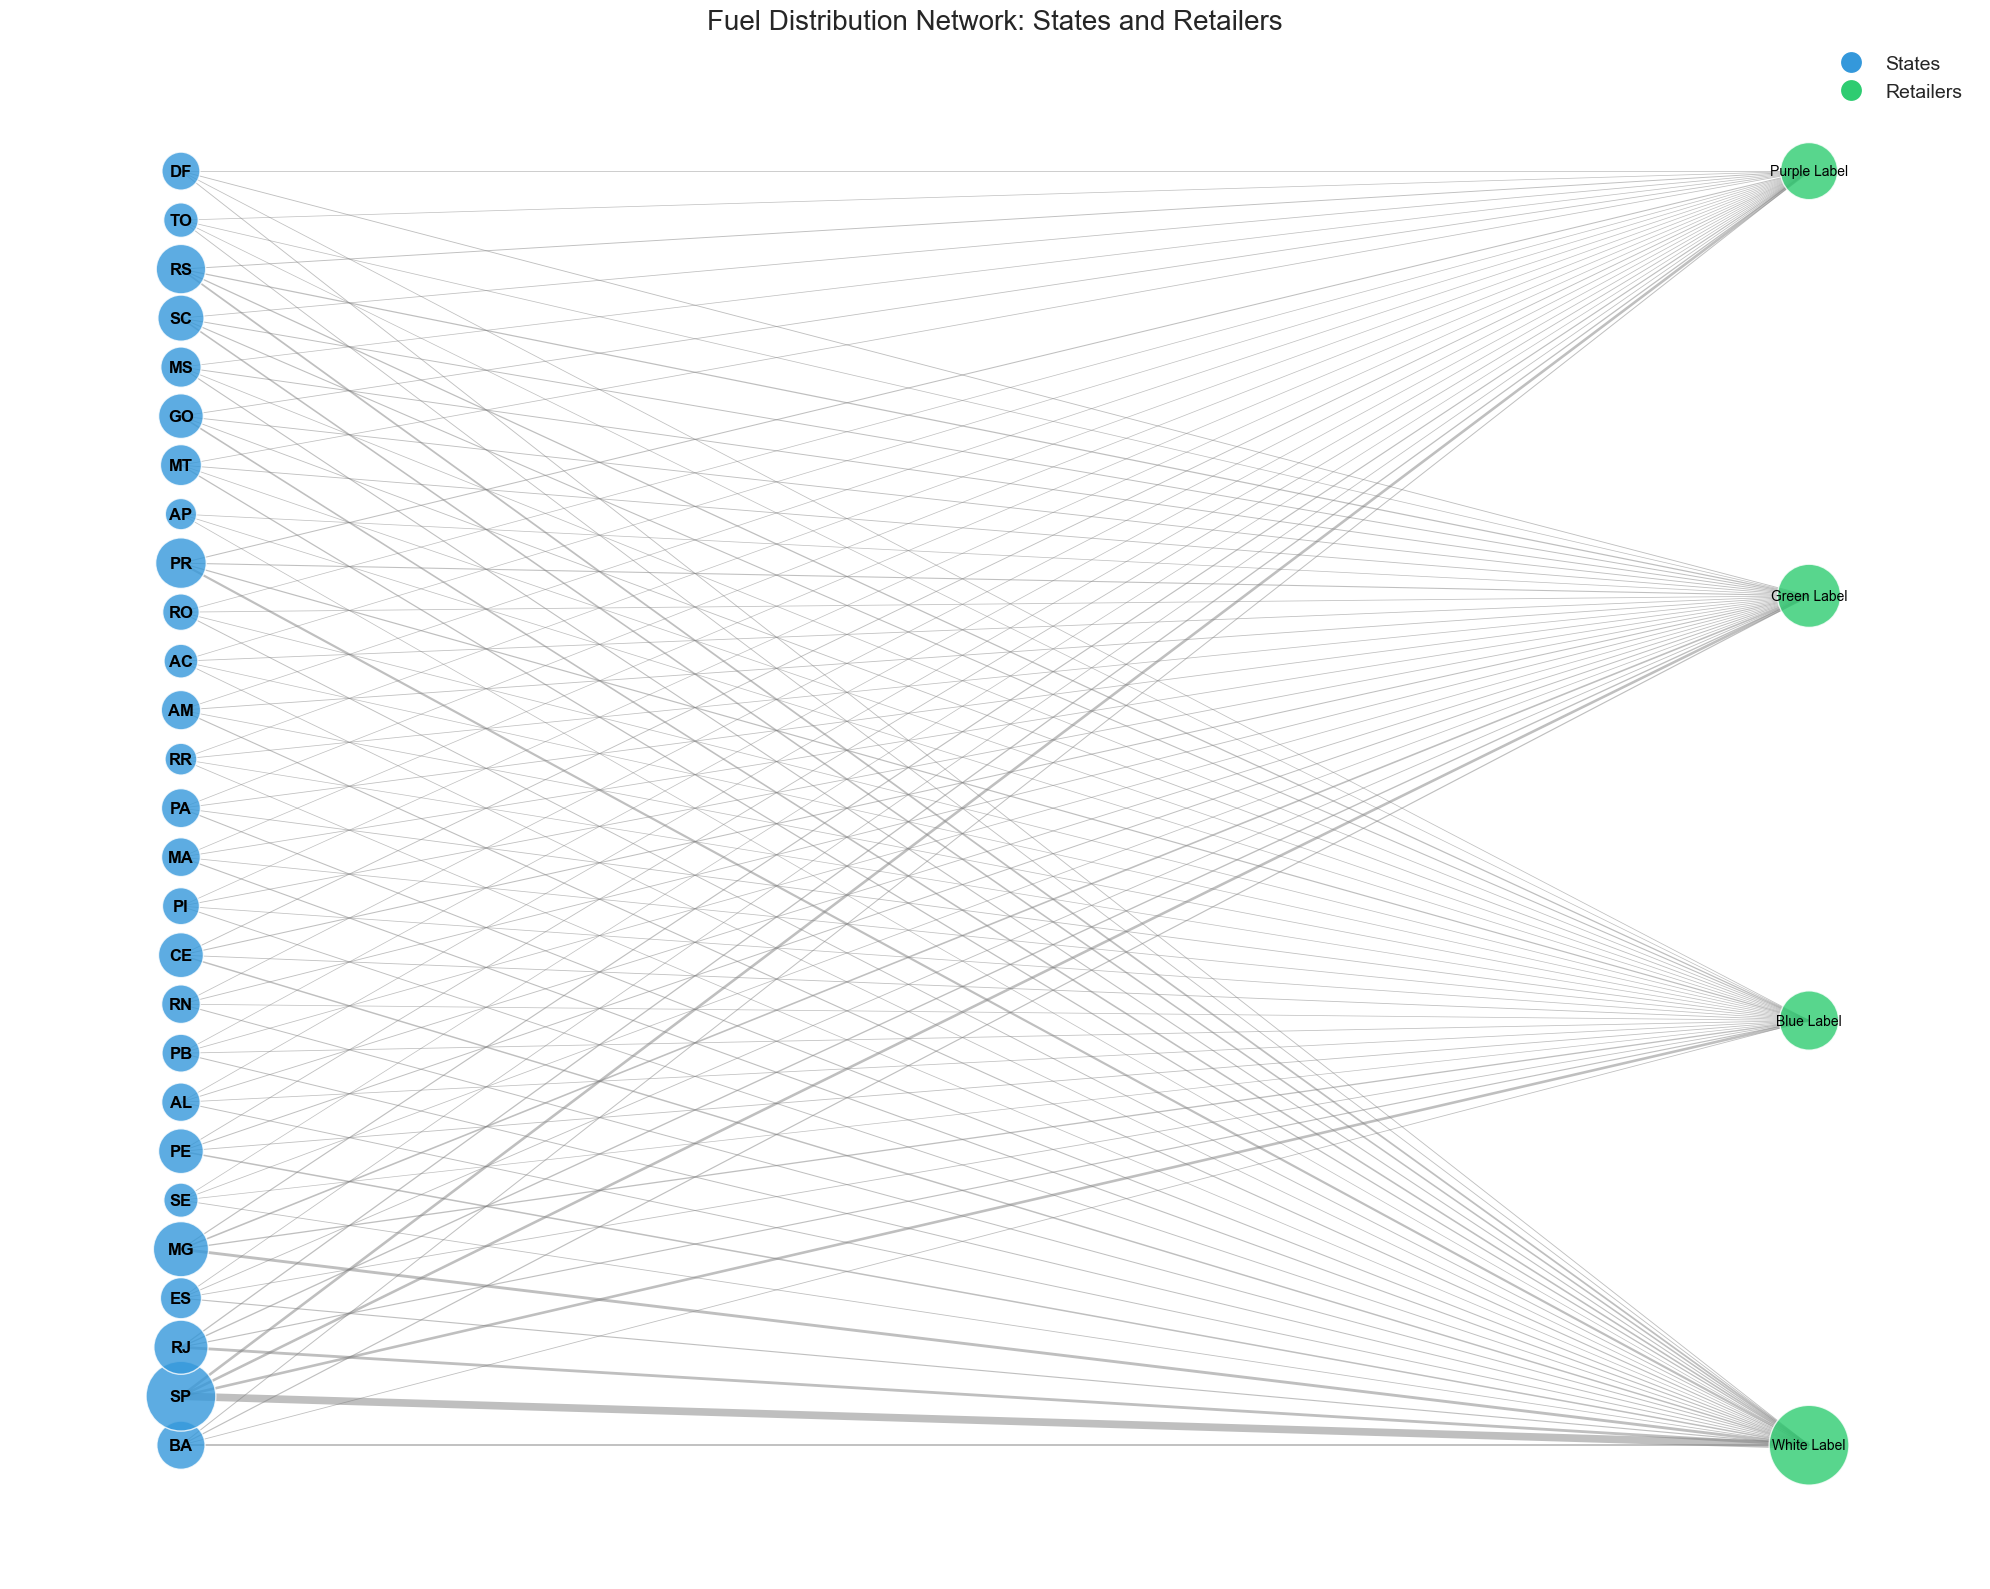

In [60]:
# 3. Visualize the network
plt.figure(figsize=(20, 16))
print("\nVisualizing the distribution network...")

# Use a bipartite layout instead of spring layout
# First, separate nodes by type
state_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'state']
retailer_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'retailer']

# Create a bipartite layout
pos = {}
# Position states on the left
for i, node in enumerate(state_nodes):
    pos[node] = (0.25, (i / (len(state_nodes) - 1 if len(state_nodes) > 1 else 1)) * 0.9 + 0.05)
# Position retailers on the right
for i, node in enumerate(retailer_nodes):
    pos[node] = (0.75, (i / (len(retailer_nodes) - 1 if len(retailer_nodes) > 1 else 1)) * 0.9 + 0.05)

# Get node sizes based on number of establishments with better scaling
node_sizes = []
max_establishments = max([G.nodes[node].get('establishments', 0) for node in G.nodes()])
for node in G.nodes():
    size = G.nodes[node].get('establishments', 0)
    # Scale the size for better visualization with a minimum size
    node_sizes.append(300 + (np.sqrt(size) / np.sqrt(max_establishments)) * 3000 if size > 0 else 300)

# Use more distinct colors for better visibility
state_color = '#3498db'  # Blue
retailer_color = '#2ecc71'  # Green

# Get node colors based on type
node_colors = []
for node in G.nodes():
    if G.nodes[node].get('type') == 'state':
        node_colors.append(state_color)
    else:
        node_colors.append(retailer_color)

# Get edge widths based on weight with better scaling
edge_widths = []
max_weight = max([G[u][v].get('weight', 1) for u, v in G.edges()])
for u, v in G.edges():
    width = G[u][v].get('weight', 1)
    # Scale the width for better visualization
    edge_widths.append(0.5 + (width / max_weight) * 5)

# Draw the network with improved aesthetics
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8, edgecolors='white', linewidths=1)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='gray', connectionstyle='arc3,rad=0.1')

# Improve label visibility
state_labels = {node: node for node in state_nodes}
retailer_labels = {node: node for node in retailer_nodes}

nx.draw_networkx_labels(G, pos, labels=state_labels, font_size=12, font_weight='bold', font_color='black')
nx.draw_networkx_labels(G, pos, labels=retailer_labels, font_size=10, font_color='black')

# Add a legend
state_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=state_color, markersize=15, label='States')
retailer_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=retailer_color, markersize=15, label='Retailers')
plt.legend(handles=[state_patch, retailer_patch], loc='upper right', fontsize=14)

plt.title('Fuel Distribution Network: States and Retailers', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()


In [65]:
# 4. Identify key hubs
print("\nIdentifying key distribution hubs...")

# Top states by centrality
top_states = centrality_df[centrality_df['type'] == 'state'].sort_values(
    'eigenvector_centrality', ascending=False).head(5)
print("\nTop 5 State Hubs by Eigenvector Centrality:")
print(top_states[['node', 'eigenvector_centrality', 'degree_centrality']])

# Top retailers by centrality
top_retailers = centrality_df[centrality_df['type'] == 'retailer'].sort_values(
    'eigenvector_centrality', ascending=False).head(5)
print("\nTop 5 Retailer Hubs by Eigenvector Centrality:")
print(top_retailers[['node', 'eigenvector_centrality', 'degree_centrality']])

# 5. Analyze hub influence on pricing
print("\nAnalyzing hub influence on regional pricing...")

# Create a dataframe with state, retailer, and price information
hub_influence = df.groupby(['sigla_uf', 'bandeira_revenda_cat']).agg({
    'avg_preco_venda': 'mean',
    'n_estabelecimentos': 'sum'
}).reset_index()

# Add centrality metrics
hub_influence = hub_influence.merge(
    centrality_df[['node', 'eigenvector_centrality']],
    left_on='sigla_uf',
    right_on='node',
    how='left'
).rename(columns={'eigenvector_centrality': 'state_centrality'}).drop('node', axis=1)

hub_influence = hub_influence.merge(
    centrality_df[['node', 'eigenvector_centrality']],
    left_on='bandeira_revenda_cat',
    right_on='node',
    how='left'
).rename(columns={'eigenvector_centrality': 'retailer_centrality'}).drop('node', axis=1)

# Calculate correlation between centrality and prices
state_price_corr = hub_influence['state_centrality'].corr(hub_influence['avg_preco_venda'])
retailer_price_corr = hub_influence['retailer_centrality'].corr(hub_influence['avg_preco_venda'])

print(f"\nCorrelation between state centrality and prices: {state_price_corr:.4f}")
print(f"Correlation between retailer centrality and prices: {retailer_price_corr:.4f}")

# 6. Visualize hub influence on pricing
plt.figure(figsize=(15, 10))

# Create a scatter plot of state centrality vs price
plt.subplot(1, 2, 1)
sns.scatterplot(x='state_centrality', y='avg_preco_venda', 
                size='n_estabelecimentos', data=hub_influence,
                sizes=(20, 500), alpha=0.7)
plt.title('State Centrality vs. Average Price')
plt.xlabel('State Centrality')
plt.ylabel('Average Price (R$)')
plt.grid(True, alpha=0.3)

# Create a scatter plot of retailer centrality vs price
plt.subplot(1, 2, 2)
sns.scatterplot(x='retailer_centrality', y='avg_preco_venda', 
                size='n_estabelecimentos', data=hub_influence,
                sizes=(20, 500), alpha=0.7)
plt.title('Retailer Centrality vs. Average Price')
plt.xlabel('Retailer Centrality')
plt.ylabel('Average Price (R$)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Community detection
print("\nDetecting communities in the distribution network...")

# Detect communities using the Louvain method
try:
    from community import community_louvain
    partition = community_louvain.best_partition(G)
    
    # Add community information to nodes
    nx.set_node_attributes(G, partition, 'community')
    
    # Count communities
    communities = set(partition.values())
    print(f"Number of communities detected: {len(communities)}")
    
    # Visualize communities
    plt.figure(figsize=(20, 16))
    
    # Color nodes by community
    cmap = plt.cm.get_cmap('tab20', len(communities))
    node_colors = [cmap(partition[node]) for node in G.nodes()]
    
    # Draw the network with communities
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.3, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title('Fuel Distribution Network Communities', fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Analyze price differences between communities
    community_prices = []
    for node in G.nodes():
        if G.nodes[node].get('type') == 'state':
            community_prices.append({
                'state': node,
                'community': partition[node],
                'avg_price': G.nodes[node].get('avg_price', 0)
            })
    
    community_price_df = pd.DataFrame(community_prices)
    community_avg_prices = community_price_df.groupby('community')['avg_price'].mean()
    
    print("\nAverage prices by community:")
    print(community_avg_prices)
    
    # Visualize price differences between communities
    plt.figure(figsize=(12, 6))
    sns.barplot(x=community_avg_prices.index, y=community_avg_prices.values)
    plt.title('Average Fuel Prices by Network Community')
    plt.xlabel('Community')
    plt.ylabel('Average Price (R$)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("Community detection requires the python-louvain package. Install with: pip install python-louvain")

# 8. Price influence analysis
print("\nAnalyzing price influence patterns...")

# Create a price influence matrix
influence_matrix = np.zeros((len(states), len(states)))
state_idx = {state: i for i, state in enumerate(states)}

# Calculate price correlations between states
price_by_state_date = df.groupby(['data', 'sigla_uf'])['avg_preco_venda'].mean().reset_index()
price_pivot = price_by_state_date.pivot(index='data', columns='sigla_uf', values='avg_preco_venda')

# Calculate correlation matrix
price_corr = price_pivot.corr()

# Visualize price correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(price_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Price Correlation Between States')
plt.tight_layout()
plt.show()

# 9. Summarize findings
print("\nNetwork Analysis Summary:")
print("-------------------------")
print(f"1. The fuel distribution network consists of {len(states)} states and {len(retailers)} retailers.")
print(f"2. We identified {len(top_states)} major state hubs and {len(top_retailers)} major retailer hubs.")
print(f"3. State centrality correlation with prices: {state_price_corr:.4f}")
print(f"4. Retailer centrality correlation with prices: {retailer_price_corr:.4f}")
try:
    print(f"5. The network can be divided into {len(communities)} distinct communities.")
except:
    print("5. Community detection was not performed.")
print("6. Price correlations between states reveal regional pricing patterns.")
print("7. Key hubs have significant influence on regional pricing structures.")


Identifying key distribution hubs...


KeyError: 'eigenvector_centrality'

# Geospatial Analysis:


In [7]:
# Geospatial Analysis of Fuel Pricing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from scipy.spatial import distance
from scipy.stats import pearsonr
import pysal
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import folium
from folium.plugins import HeatMap, MarkerCluster

print("Performing detailed geospatial analysis of fuel pricing...")
# 1. Prepare municipality-level data
print("\nAggregating data at municipality level...")
municipality_data = df.groupby(['id_municipio', 'id_municipio_nome']).agg({
    'avg_preco_venda': 'mean',
    'n_estabelecimentos': 'sum',
    'sigla_uf': 'first',
    'avg_preco_compra': 'mean'
}).reset_index()

# Calculate profit margin
municipality_data['profit_margin'] = municipality_data['avg_preco_venda'] - municipality_data['avg_preco_compra']
municipality_data['profit_margin_pct'] = (municipality_data['profit_margin'] / municipality_data['avg_preco_compra']) * 100


Performing detailed geospatial analysis of fuel pricing...

Aggregating data at municipality level...



Creating municipality-level choropleth map...


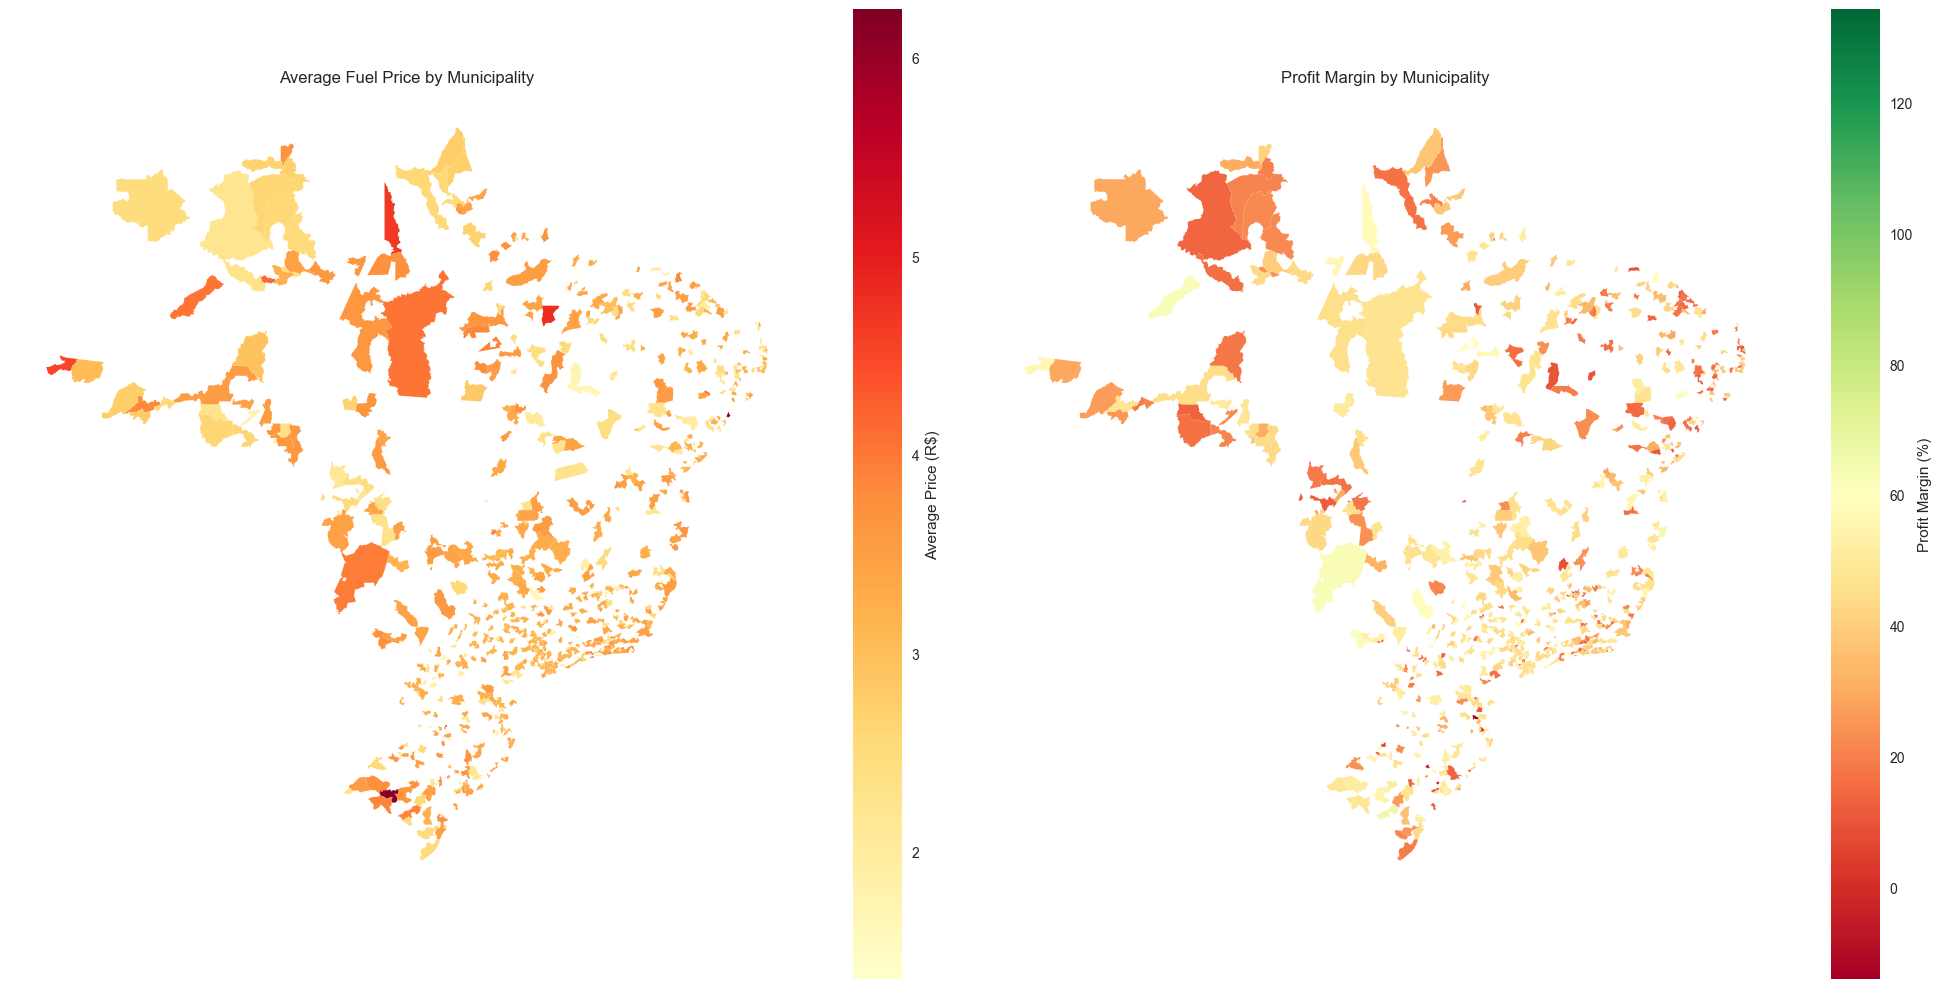

In [8]:
# Try to load from GitHub (public source)
brazil_municipalities = gpd.read_file('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json')

# Clean and prepare the GeoDataFrame
brazil_municipalities['id_municipio'] = brazil_municipalities['id'].astype(str)

# Merge with our data
geo_data = brazil_municipalities.merge(municipality_data, on='id_municipio', how='right')

# Check if we have geometry data
if geo_data.geometry.isna().all():
    raise ValueError("No geometry data available after merge")

# 3. Create detailed choropleth map at municipality level
print("\nCreating municipality-level choropleth map...")

# Set up the figure
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot average price
geo_data.plot(column='avg_preco_venda', 
                cmap='YlOrRd', 
                legend=True,
                legend_kwds={'label': "Average Price (R$)"},
                ax=ax[0])
ax[0].set_title('Average Fuel Price by Municipality')
ax[0].axis('off')

# Plot profit margin percentage
geo_data.plot(column='profit_margin_pct', 
                cmap='RdYlGn', 
                legend=True,
                legend_kwds={'label': "Profit Margin (%)"},
                ax=ax[1])
ax[1].set_title('Profit Margin by Municipality')
ax[1].axis('off')

plt.tight_layout()
plt.show()



In [11]:
# 4. Spatial autocorrelation analysis
print("\nPerforming spatial autocorrelation analysis...")

# Import necessary libraries
from libpysal.weights import Queen
from esda.moran import Moran

# Make sure geometry is valid
geo_data = geo_data.dropna(subset=['geometry'])

# Create spatial weights matrix
try:
    w = Queen.from_dataframe(geo_data, use_index=True)
    
    # Calculate Moran's I for average price
    moran = Moran(geo_data['avg_preco_venda'], w)
    print(f"Moran's I for average price: {moran.I:.4f}")
    print(f"p-value: {moran.p_sim:.4f}")
    
    if moran.p_sim < 0.05:
        print("There is significant spatial autocorrelation in fuel prices")
    else:
        print("No significant spatial autocorrelation detected")
    
    # Calculate Moran's I for profit margin
    # Use profit_margin_pct instead of profit_margin
    moran_profit = Moran(geo_data['profit_margin_pct'], w)
    print(f"Moran's I for profit margin: {moran_profit.I:.4f}")
    print(f"p-value: {moran_profit.p_sim:.4f}")
except Exception as e:
    print(f"Error in spatial analysis: {e}")
    # Create a placeholder weights object for the next cell
    import libpysal
    w = libpysal.weights.W.from_shapefile(geo_data.geometry)



Performing spatial autocorrelation analysis...
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 27, ' is an island (no neighbors)')
('WARNING: ', 29, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 36, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 43, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 55, ' is an island (no neighbors)')
('WARNING: ', 57, ' is an island (no neighbors)')
('WARNING: ', 58, ' is an island (no neighbors)')
('WARNING: ', 66, ' is an island (no neighbors)')
('WARNING: ', 67, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('WARNING: ', 71, ' is an island (no neighbors)')
('WARNING: ', 74, ' is an island (no neighbors)')
('W

/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 270 disconnected components.
 There are 152 islands with ids: 5, 27, 29, 30, 36, 42, 43, 44, 45, 52, 55, 57, 58, 66, 67, 68, 69, 71, 74, 77, 79, 80, 84, 85, 86, 88, 90, 98, 99, 100, 101, 103, 108, 111, 117, 118, 123, 125, 128, 129, 130, 139, 142, 143, 146, 148, 149, 156, 157, 159, 169, 178, 184, 186, 187, 189, 194, 196, 207, 214, 218, 228, 234, 238, 240, 241, 243, 248, 252, 265, 266, 268, 274, 276, 277, 278, 283, 285, 287, 289, 290, 292, 297, 300, 310, 311, 312, 313, 322, 385, 388, 400, 416, 422, 425, 444, 446, 447, 451, 453, 489, 490, 503, 509, 515, 517, 519, 522, 524, 527, 528, 529, 530, 531, 537, 538, 540, 541, 542, 546, 561, 571, 573, 576, 580, 583, 585, 589, 594, 600, 603, 605, 610, 612, 617, 618, 621, 625, 631, 635, 638, 642, 644, 649, 650, 652, 669, 670, 673, 683, 685, 689.
  warnings.warn(message)



Identifying local spatial clusters...


/Users/maruanottoni/miniforge3/envs/mlp/lib/python3.8/site-packages/esda/moran.py:1059: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


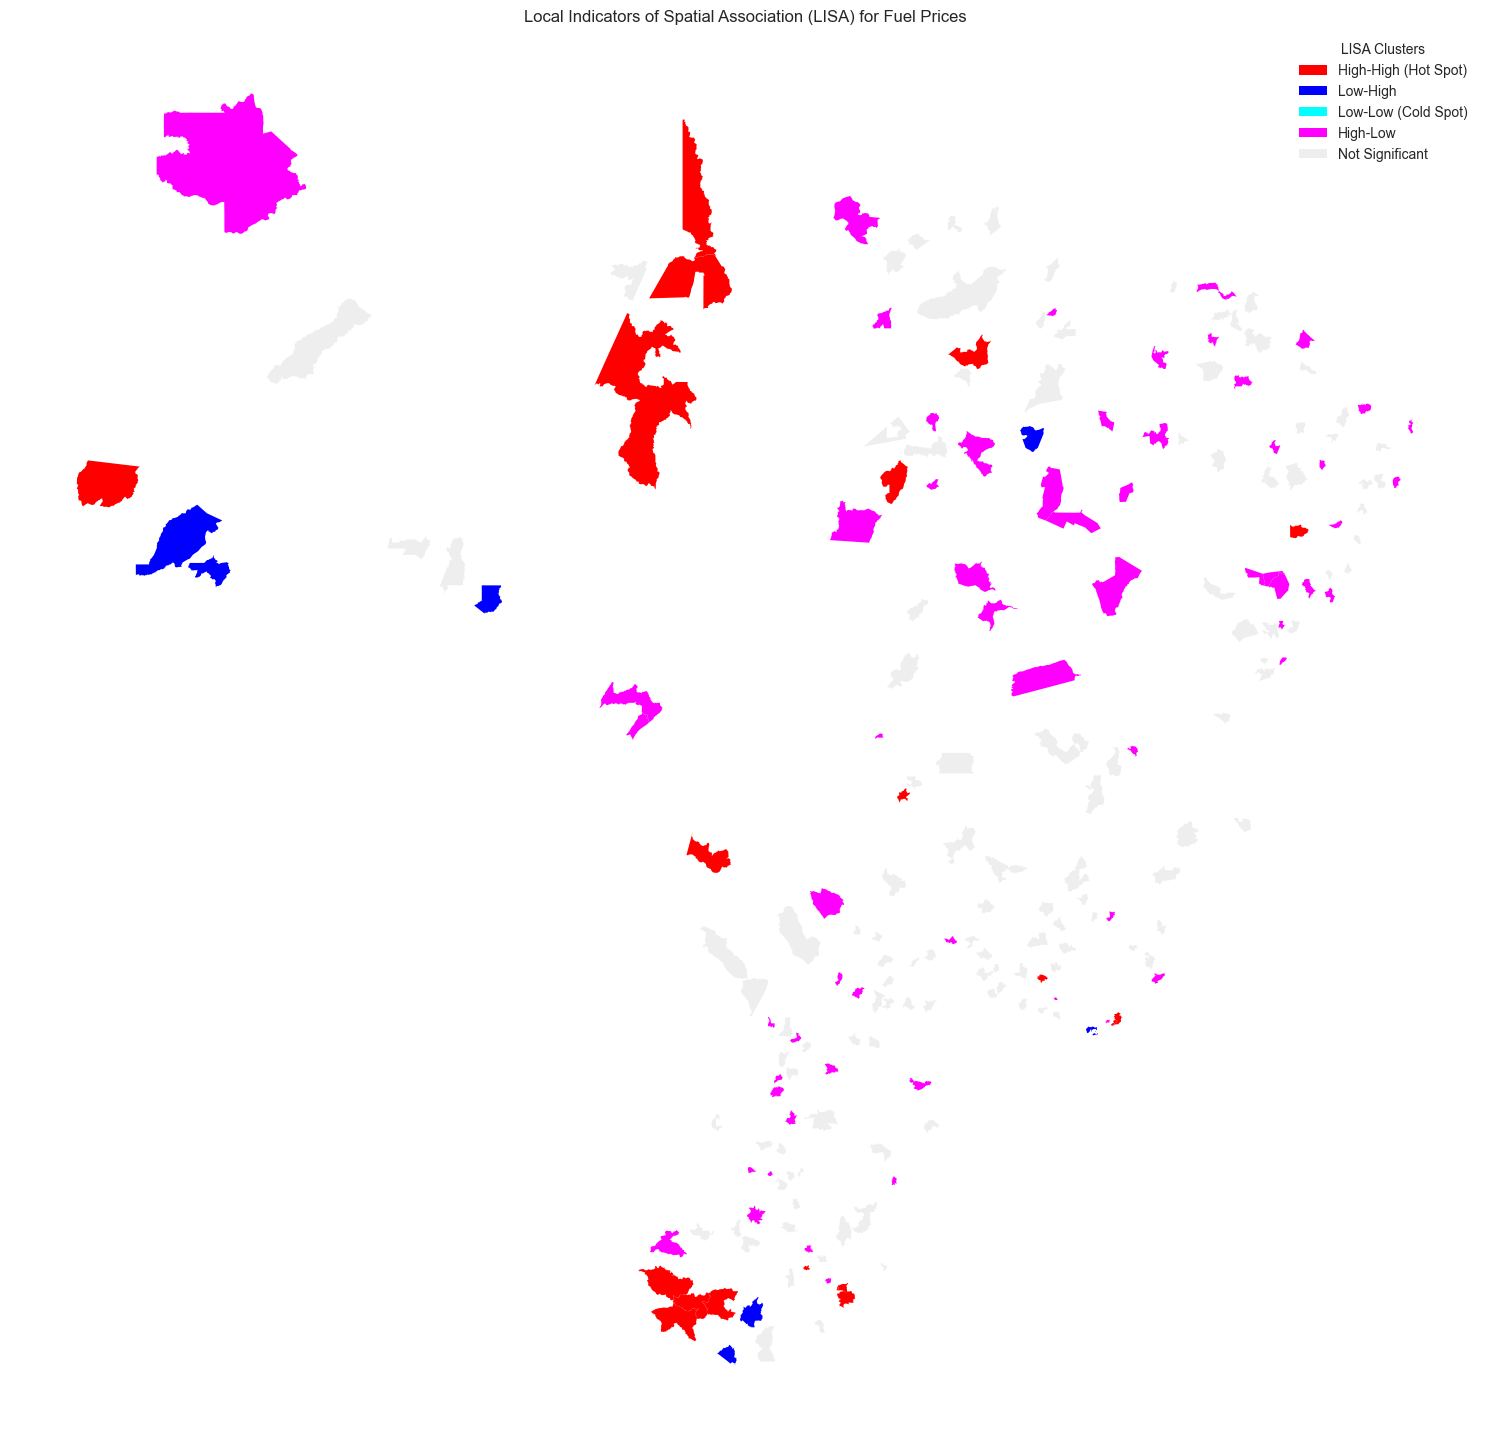

In [12]:
# 5. Local Indicators of Spatial Association (LISA)
print("\nIdentifying local spatial clusters...")

from esda.moran import Moran_Local

# Calculate local Moran's I
lisa = Moran_Local(geo_data['avg_preco_venda'], w)

# Add LISA results to the dataframe
geo_data['lisa_I'] = lisa.Is
geo_data['lisa_p_value'] = lisa.p_sim
geo_data['lisa_quadrant'] = np.nan

# Assign quadrants: 1=HH, 2=LH, 3=LL, 4=HL
sig = lisa.p_sim < 0.05
geo_data.loc[sig & (lisa.q == 1), 'lisa_quadrant'] = 1  # High-High
geo_data.loc[sig & (lisa.q == 2), 'lisa_quadrant'] = 2  # Low-High
geo_data.loc[sig & (lisa.q == 3), 'lisa_quadrant'] = 3  # Low-Low
geo_data.loc[sig & (lisa.q == 4), 'lisa_quadrant'] = 4  # High-Low

# Plot LISA clusters
fig, ax = plt.subplots(figsize=(15, 15))

# Define colors for each quadrant
lisa_colors = {
    1: '#FF0000',  # High-High (hot spots) - Red
    2: '#0000FF',  # Low-High - Blue
    3: '#00FFFF',  # Low-Low (cold spots) - Cyan
    4: '#FF00FF',  # High-Low - Magenta
    np.nan: '#EEEEEE'  # Not significant - Light Gray
}

# Create a custom colormap
from matplotlib.colors import ListedColormap
lisa_cmap = ListedColormap([lisa_colors[i] for i in [1, 2, 3, 4, np.nan]])

# Plot LISA clusters
geo_data.plot(column='lisa_quadrant', 
                categorical=True,
                cmap=lisa_cmap,
                legend=True,
                ax=ax)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=lisa_colors[1], label='High-High (Hot Spot)'),
    Patch(facecolor=lisa_colors[2], label='Low-High'),
    Patch(facecolor=lisa_colors[3], label='Low-Low (Cold Spot)'),
    Patch(facecolor=lisa_colors[4], label='High-Low'),
    Patch(facecolor=lisa_colors[np.nan], label='Not Significant')
]
ax.legend(handles=legend_elements, title='LISA Clusters')

ax.set_title('Local Indicators of Spatial Association (LISA) for Fuel Prices')
ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# 6. Create interactive map with Folium
print("\nCreating interactive map...")

# Calculate center of Brazil
center_lat = geo_data.geometry.centroid.y.mean()
center_lon = geo_data.geometry.centroid.x.mean()

# Create base map
m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles='CartoDB positron')

# Add choropleth layer
folium.Choropleth(
    geo_data=geo_data,
    name='Fuel Prices',
    data=geo_data,
    columns=['id_municipio', 'avg_preco_venda'],
    key_on='feature.properties.id_municipio',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Fuel Price (R$)'
).add_to(m)

# Add LISA cluster layer
# Convert LISA quadrants to colors
geo_data['lisa_color'] = geo_data['lisa_quadrant'].map(lisa_colors)

# Only include significant clusters
lisa_geo = geo_data[~geo_data['lisa_quadrant'].isna()]

# Add GeoJSON layer for LISA clusters
folium.GeoJson(
    lisa_geo,
    name='LISA Clusters',
    style_function=lambda feature: {
        'fillColor': feature['properties']['lisa_color'],
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['id_municipio_nome', 'avg_preco_venda', 'lisa_quadrant'],
        aliases=['Municipality', 'Avg Price', 'Cluster Type'],
        localize=True
    )
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
m.save('fuel_price_map.html')
print("Interactive map saved as 'fuel_price_map.html'")


Creating interactive map...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/2647962506.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = geo_data.geometry.centroid.y.mean()
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/2647962506.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = geo_data.geometry.centroid.x.mean()


Interactive map saved as 'fuel_price_map.html'



Analyzing price variation with distance...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['centroid'] = geo_data.geometry.centroid
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['latitude'] = geo_data.centroid.y
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['longitude'] = geo_data.centroid.x


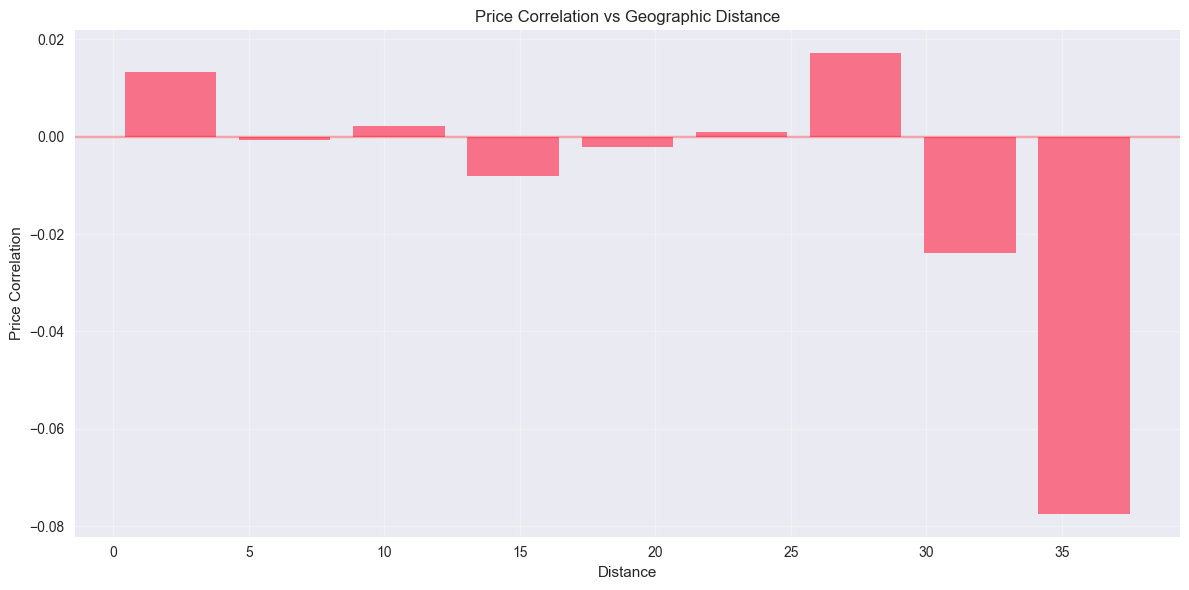


Analyzing price variation with distance...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['centroid'] = geo_data.geometry.centroid
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['latitude'] = geo_data.centroid.y
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_17996/4224240205.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['longitude'] = geo_data.centroid.x


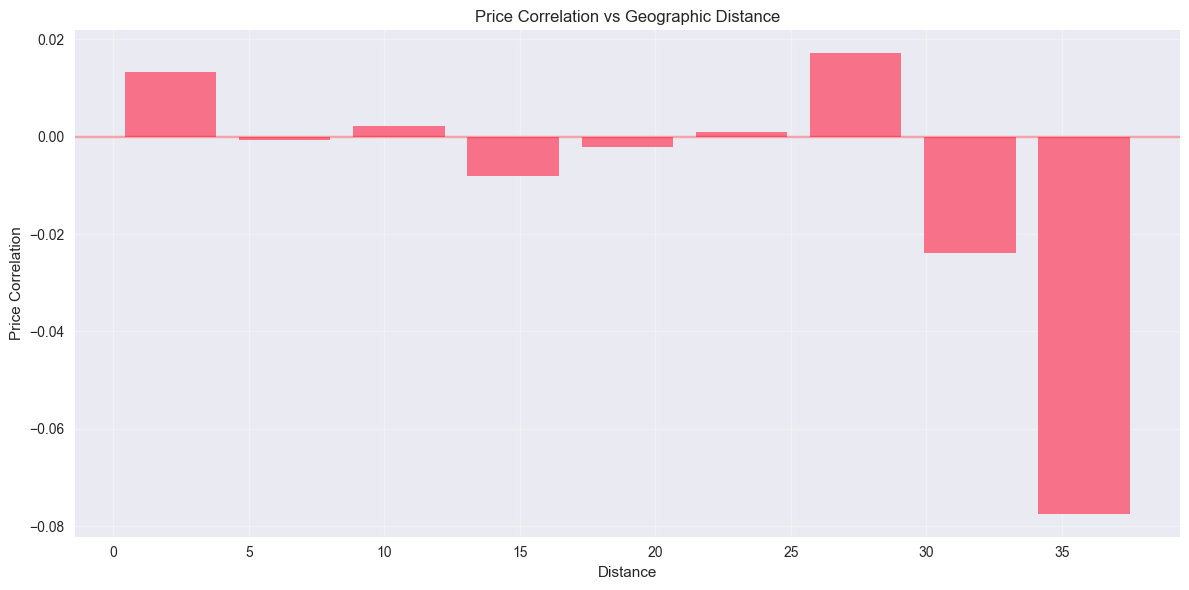

In [14]:
# 7. Distance-based price analysis
print("\nAnalyzing price variation with distance...")

# Calculate centroids for each municipality
geo_data['centroid'] = geo_data.geometry.centroid
geo_data['latitude'] = geo_data.centroid.y
geo_data['longitude'] = geo_data.centroid.x

# Calculate distance matrix between municipalities
coords = geo_data[['latitude', 'longitude']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# Create distance bins
dist_bins = np.linspace(0, dist_matrix.max(), 10)

# Calculate price correlation at different distances
distance_correlations = []

for i in range(len(dist_bins)-1):
    lower = dist_bins[i]
    upper = dist_bins[i+1]
    
    # Get municipality pairs in this distance range
    pairs = []
    for j in range(len(geo_data)):
        for k in range(j+1, len(geo_data)):
            if lower <= dist_matrix[j, k] < upper:
                pairs.append((j, k))
    
    if len(pairs) > 1:
        # Get prices for these pairs
        prices1 = [geo_data.iloc[p[0]]['avg_preco_venda'] for p in pairs]
        prices2 = [geo_data.iloc[p[1]]['avg_preco_venda'] for p in pairs]
        
        # Calculate correlation
        corr, p_value = pearsonr(prices1, prices2)
        
        distance_correlations.append({
            'distance_min': lower,
            'distance_max': upper,
            'avg_distance': (lower + upper) / 2,
            'correlation': corr,
            'p_value': p_value,
            'n_pairs': len(pairs)
        })

# Convert to DataFrame
distance_corr_df = pd.DataFrame(distance_correlations)

# Plot correlation vs distance
plt.figure(figsize=(12, 6))
plt.bar(distance_corr_df['avg_distance'], distance_corr_df['correlation'], 
        width=(dist_bins[1] - dist_bins[0]) * 0.8)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Price Correlation vs Geographic Distance')
plt.xlabel('Distance')
plt.ylabel('Price Correlation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# 7. Distance-based price analysis
print("\nAnalyzing price variation with distance...")

# Calculate centroids for each municipality
geo_data['centroid'] = geo_data.geometry.centroid
geo_data['latitude'] = geo_data.centroid.y
geo_data['longitude'] = geo_data.centroid.x

# Calculate distance matrix between municipalities
coords = geo_data[['latitude', 'longitude']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# Create distance bins
dist_bins = np.linspace(0, dist_matrix.max(), 10)

# Calculate price correlation at different distances
distance_correlations = []

for i in range(len(dist_bins)-1):
    lower = dist_bins[i]
    upper = dist_bins[i+1]
    
    # Get municipality pairs in this distance range
    pairs = []
    for j in range(len(geo_data)):
        for k in range(j+1, len(geo_data)):
            if lower <= dist_matrix[j, k] < upper:
                pairs.append((j, k))
    
    if len(pairs) > 1:
        # Get prices for these pairs
        prices1 = [geo_data.iloc[p[0]]['avg_preco_venda'] for p in pairs]
        prices2 = [geo_data.iloc[p[1]]['avg_preco_venda'] for p in pairs]
        
        # Calculate correlation
        corr, p_value = pearsonr(prices1, prices2)
        
        distance_correlations.append({
            'distance_min': lower,
            'distance_max': upper,
            'avg_distance': (lower + upper) / 2,
            'correlation': corr,
            'p_value': p_value,
            'n_pairs': len(pairs)
        })

# Convert to DataFrame
distance_corr_df = pd.DataFrame(distance_correlations)

# Plot correlation vs distance
plt.figure(figsize=(12, 6))
plt.bar(distance_corr_df['avg_distance'], distance_corr_df['correlation'], 
        width=(dist_bins[1] - dist_bins[0]) * 0.8)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Price Correlation vs Geographic Distance')
plt.xlabel('Distance')
plt.ylabel('Price Correlation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()